# Paired DE Analysis with DESeq2
- Last update: 4.10.2021
- Last run by Isabella Casini
- Using R environment (seems to have the things from r4-base env)

In [1]:
# setwd(scan(".cwd", what = character()))
# file personal to Guillermo

In [1]:
library(tidyverse)
library(DESeq2)
library(ggpubr)
library(tximport)

library(factoextra)
library(FactoMineR)
library(pheatmap)
library(EnhancedVolcano)
library(cowplot)

library(gplots)

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.5     v dplyr   1.0.7
v tidyr   1.1.4     v stringr 1.4.0
v readr   2.0.2     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:dplyr':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The follow

In [2]:
# OUTPUT_DIR = "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run/images"
OUTPUT_DIR = "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/images"

In [4]:
# Need to make the directory before I can write out files theres
dir.create(file.path(OUTPUT_DIR))


Warning message in dir.create(file.path(OUTPUT_DIR)):
"'F:\\Experimental_Work\Transcriptomics\F6_Exp\DE_Guillermo\Isabella_run2\images' already exists"


In [5]:
DESEQ2_FORMULA = "~Condition"
MIN_COUNTS = 10

PADJ_CUTOFF = 0.05
LFC_CUTOFF_UP = 1.0
LFC_CUTOFF_DOWN = -1.0

## Gene dictionary

In [6]:
# df = read_tsv("F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run/df_gene_combined_20211004.txt", show_col_types = FALSE)
df = read_tsv("F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/df_gene_combined_20211004.txt", show_col_types = FALSE)

- How many records have the word `None` for each genome?

In [7]:
df %>%
    summarize(across(everything(), ~sum(str_detect(.x, "None"))))

DH,ZZ,MM
<int>,<int>,<int>
0,11,81


- The differential expression analysis is done taking DH genes as the reference set
- **That means all the genes in the counts file are translated to DH genes**

Here the dictionaries `df.dh`, `df.mm`, and `df.zz` are created. Each table contains two columns:
- `TXNAME`: the gene in the organism
- `GENEID` the reference gene (in DH)

In [8]:
df %>%
    select(DH) %>%
    unique() %>%
    mutate(TXNAME = DH) %>%
    dplyr::rename(GENEID = DH) %>%
    select(TXNAME, GENEID) -> df.dh

df %>%
    select(MM, DH) %>% filter(!str_detect(MM, "None")) %>%
    unique() %>%
    dplyr::rename(TXNAME = MM, GENEID = DH) %>%
    select(TXNAME, GENEID) -> df.mm

df %>%
    select(ZZ, DH) %>% filter(!str_detect(ZZ, "None")) %>%
    unique() %>%
    dplyr::rename(TXNAME = ZZ, GENEID = DH) %>%
    select(TXNAME, GENEID) -> df.zz

- `genes_X` is a vector of strings with the IDs of the reference genes (`GENEID`) for the organism `X`.

In [9]:
df.dh %>% pull(GENEID) -> genes_dh
df.mm %>% pull(GENEID) -> genes_mm
df.zz %>% pull(GENEID) -> genes_zz

In [10]:
# gives the head of the dataframe df.mm
df.mm%>% head

TXNAME,GENEID
<chr>,<chr>
ISG34_02435,ISG35_00005
ISG34_02440,ISG35_00010
ISG34_02445,ISG35_00015
ISG34_02450,ISG35_00020
ISG34_02455,ISG35_00025
ISG34_02460,ISG35_00030


### Common genes for comparisons

- `common.X_Y` is a string vector with the common reference genes between the `X` and `Y` organisms. In R, the dot (`.`) can be part of a variable name.

In [11]:
intersect(genes_zz, genes_dh) -> common.ZZ_DH
intersect(genes_mm, genes_dh) -> common.MM_DH
intersect(genes_zz, genes_mm) -> common.ZZ_MM

- The `tx2gene_X_Y` files are required by DESeq2 while importing Salmon counts.

In [12]:
data.frame(x = common.ZZ_DH, y = common.ZZ_DH) %>%
#     write_tsv("F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/tx2gene_ZZ_DH.tsv", col_names = FALSE)

data.frame(x = common.MM_DH, y = common.MM_DH) %>%
#     write_tsv("F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/tx2gene_MM_DH.tsv", col_names = FALSE)

data.frame(x = common.ZZ_MM, y = common.ZZ_MM) %>%
#     write_tsv("F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/tx2gene_ZZ_MM.tsv", col_names = FALSE)

## Samples table

In [13]:
read.table("F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/samples_F6_fixed.csv", header = TRUE) %>%
    mutate(Condition = str_replace(Condition, "Z-245", "ZZ")) %>%
    dplyr::select(-Read1, -Read2) -> s

In [14]:
s %>% filter(Condition == "DH") %>% pull(Sample) -> dh
s %>% filter(Condition == "ZZ") %>% pull(Sample) -> zz
s %>% filter(Condition == "MM") %>% pull(Sample) -> mm

In [15]:
print(dh)
print(zz)
print(mm)

[1] "S1R4" "S1R5" "S2R6" "S2R8"
[1] "S1R7" "S2R2" "S2R4" "S2R5"
[1] "S1R2" "S2R1" "S2R3" "S2R7"


In [16]:
paste0("F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/salmon_DH/", dh, "_quant.sf") -> dh_files
paste0("F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/Updated_salmon_MM/", mm, "_quant.sf") -> mm_files
paste0("F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/Updated_salmon_ZZ/", zz, "_quant.sf") -> zz_files

In [17]:
print(dh_files)
print(mm_files)
print(zz_files)

[1] "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/salmon_DH/S1R4_quant.sf"
[2] "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/salmon_DH/S1R5_quant.sf"
[3] "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/salmon_DH/S2R6_quant.sf"
[4] "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/salmon_DH/S2R8_quant.sf"
[1] "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/Updated_salmon_MM/S1R2_quant.sf"
[2] "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/Updated_salmon_MM/S2R1_quant.sf"
[3] "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/Updated_salmon_MM/S2R3_quant.sf"
[4] "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/Updated_salmon_MM/S2R7_quant.sf"
[1] "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/Updated_salmon_ZZ/S1R7_quant.sf"
[2] "F://Experimental_Work/Transcriptomics

## Metadata for Comparisons

In [18]:
s %>%
    filter(Condition %in% c("ZZ", "DH")) %>%
    mutate(Condition = as.factor(Condition)) %>%
    column_to_rownames("Sample") -> meta.zz_dh

meta.zz_dh$Condition = fct_relevel(meta.zz_dh$Condition, 'DH')

In [19]:
s %>%
    filter(Condition %in% c("MM", "DH")) %>%
    mutate(Condition = as.factor(Condition)) %>%
    column_to_rownames("Sample") -> meta.mm_dh

meta.mm_dh$Condition = fct_relevel(meta.mm_dh$Condition, 'DH')

In [20]:
s %>%
    filter(Condition %in% c("ZZ", "MM")) %>%
    mutate(Condition = as.factor(Condition)) %>%
    column_to_rownames("Sample") -> meta.zz_mm

meta.zz_mm$Condition = fct_relevel(meta.zz_mm$Condition, 'MM')

In [21]:
paste0("F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/counts_translated_ZZ_DH/", c(zz, dh), "_quant.sf") -> COUNTS_ZZ_DH

In [22]:
paste0("F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/counts_translated_MM_DH/", c(mm, dh), "_quant.sf") -> COUNTS_MM_DH

In [23]:
paste0("F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/counts_translated_ZZ_MM/", c(zz, mm), "_quant.sf") -> COUNTS_ZZ_MM

## Translate Salmon Counts

In [24]:
translate_geneids <- function(FILE, df_map, common_genes, output_dir) {
    dir.create(output_dir, showWarnings = FALSE)
    df = read_tsv(FILE, show_col_types = FALSE)

    df %>% colnames -> cn
    df %>%
        left_join(df_map, by = c("Name" = "TXNAME")) %>%
        filter(GENEID %in% common_genes) %>%
        select(-Name) %>%
        dplyr::rename(Name = GENEID) %>%
        arrange(Name) %>%
        select(all_of(cn)) -> df
    
    df %>%
#         write_tsv(file.path(output_dir, basename(FILE)))
}

In [25]:
# translate_geneids <- function(FILE, df_map, output_dir, common_genes) {
#     dir.create(output_dir, showWarnings = FALSE)
#     sample = str_split(FILE, "/", simplify = TRUE)
#     fn = paste0(sample[5], "_quant.sf")
    
#     OUTFILE = file.path(output_dir, fn)
# #     print(OUTFILE)
#     df = read_tsv(FILE, show_col_types = FALSE)
    
#     df %>% colnames -> cn
#     df %>%
#         left_join(df_map, by = c("Name" = "TXNAME")) %>%
#         filter(GENEID %in% common_genes) %>%
#         select(-Name) %>%
#         dplyr::rename(Name = GENEID) %>%
#         arrange(Name) %>%
#         select(all_of(cn)) %>%
#         write_tsv(OUTFILE)
# }

In [26]:
# lapply(zz_files, translate_geneids,
#        df_map = df.zz, common_genes = common.ZZ_DH,
#        output_dir = "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run/counts_translated_ZZ_DH") %>% invisible()

# lapply(dh_files, translate_geneids,
#        df_map = df.dh, common_genes = common.ZZ_DH,
#        output_dir = "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run/counts_translated_ZZ_DH") %>% invisible()


lapply(zz_files, translate_geneids,
       df_map = df.zz, common_genes = common.ZZ_DH,
#        output_dir = "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/counts_translated_ZZ_DH") %>% invisible()

lapply(dh_files, translate_geneids,
       df_map = df.dh, common_genes = common.ZZ_DH,
#        output_dir = "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/counts_translated_ZZ_DH") %>% invisible()


# lapply(
#     dh_files, translate_geneids, df_map = bind_rows(df.zz, df.dh),
#     common_genes = common.ZZ_DH,
#     output_dir = "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/counts_translated_ZZ_DH") %>% invisible()

In [27]:
# lapply(mm_files, translate_geneids,
#        df_map = df.mm, common_genes = common.MM_DH,
#        output_dir = "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run/counts_translated_MM_DH") %>% invisible()

# lapply(dh_files, translate_geneids,
#        df_map = df.dh, common_genes = common.MM_DH,
#        output_dir = "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run/counts_translated_MM_DH") %>% invisible()

lapply(mm_files, translate_geneids,
       df_map = df.mm, common_genes = common.MM_DH,
#        output_dir = "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/counts_translated_MM_DH") %>% invisible()

lapply(dh_files, translate_geneids,
       df_map = df.dh, common_genes = common.MM_DH,
#        output_dir = "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/counts_translated_MM_DH") %>% invisible()



# lapply(
#     mm_files, translate_geneids, df_map = bind_rows(df.mm, df.dh),
#     common_genes = common.MM_DH,
#     output_dir = "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/counts_translated_MM_DH") %>% invisible()

In [28]:
# lapply(zz_files, translate_geneids,
#        df_map = df.zz, common_genes = common.ZZ_MM,
#        output_dir = "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run/counts_translated_ZZ_MM") %>% invisible()

# lapply(mm_files, translate_geneids,
#        df_map = df.mm, common_genes = common.ZZ_MM,
#        output_dir = "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run/counts_translated_ZZ_MM") %>% invisible()

lapply(zz_files, translate_geneids,
       df_map = df.zz, common_genes = common.ZZ_MM,
#        output_dir = "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/counts_translated_ZZ_MM") %>% invisible()

lapply(mm_files, translate_geneids,
       df_map = df.mm, common_genes = common.ZZ_MM,
#        output_dir = "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/counts_translated_ZZ_MM") %>% invisible()



# lapply(
#     zz_files, translate_geneids, df_map = bind_rows(df.zz, df.mm),
#     common_genes = common.ZZ_MM,
#     output_dir = "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/counts_translated_ZZ_MM") %>% invisible()

In [29]:
paste0("F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/counts_translated_ZZ_DH/", rownames(meta.zz_dh), "_quant.sf") -> COUNTS_ZZ_DH

In [30]:
paste0("F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/counts_translated_MM_DH/", rownames(meta.mm_dh), "_quant.sf") -> COUNTS_MM_DH

In [31]:
paste0("F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/counts_translated_ZZ_MM/", rownames(meta.zz_mm), "_quant.sf") -> COUNTS_ZZ_MM

In [32]:
print(COUNTS_ZZ_DH)

[1] "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/counts_translated_ZZ_DH/S1R4_quant.sf"
[2] "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/counts_translated_ZZ_DH/S1R5_quant.sf"
[3] "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/counts_translated_ZZ_DH/S2R6_quant.sf"
[4] "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/counts_translated_ZZ_DH/S2R8_quant.sf"
[5] "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/counts_translated_ZZ_DH/S1R7_quant.sf"
[6] "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/counts_translated_ZZ_DH/S2R2_quant.sf"
[7] "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/counts_translated_ZZ_DH/S2R4_quant.sf"
[8] "F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/counts_translated_ZZ_DH/S2R5_quant.sf"


## ZZ vs DH

In [33]:
COUNTS = COUNTS_ZZ_DH
META = meta.zz_dh
COMPARISON = "ZZ_DH"
TX2GENE = read_tsv("F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/tx2gene_ZZ_DH.tsv", col_names = c("TXNAME", "GENEID"), show_col_types = FALSE)

### Read Salmon Counts

In [34]:
txi = tximport(COUNTS, type = "salmon", tx2gene = TX2GENE)

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 


summarizing abundance

summarizing counts

summarizing length



In [35]:
dds = DESeqDataSetFromTximport(txi, colData = META, design = as.formula(DESEQ2_FORMULA))
keep = rowMeans(counts(dds)) >= MIN_COUNTS
dds = dds[keep,]

using counts and average transcript lengths from tximport



### Principal Component Analysis

In [36]:
rld = rlog(dds, blind = FALSE)

using 'avgTxLength' from assays(dds), correcting for library size



**Calculate the variance for each gene**

In [37]:
rv = rowVars(assay(rld))

**Principal component analysis**

In [38]:
t(assay(rld)) -> pca_mtx
res.pca = PCA(pca_mtx, graph = FALSE)

**Biplot of samples and genes**

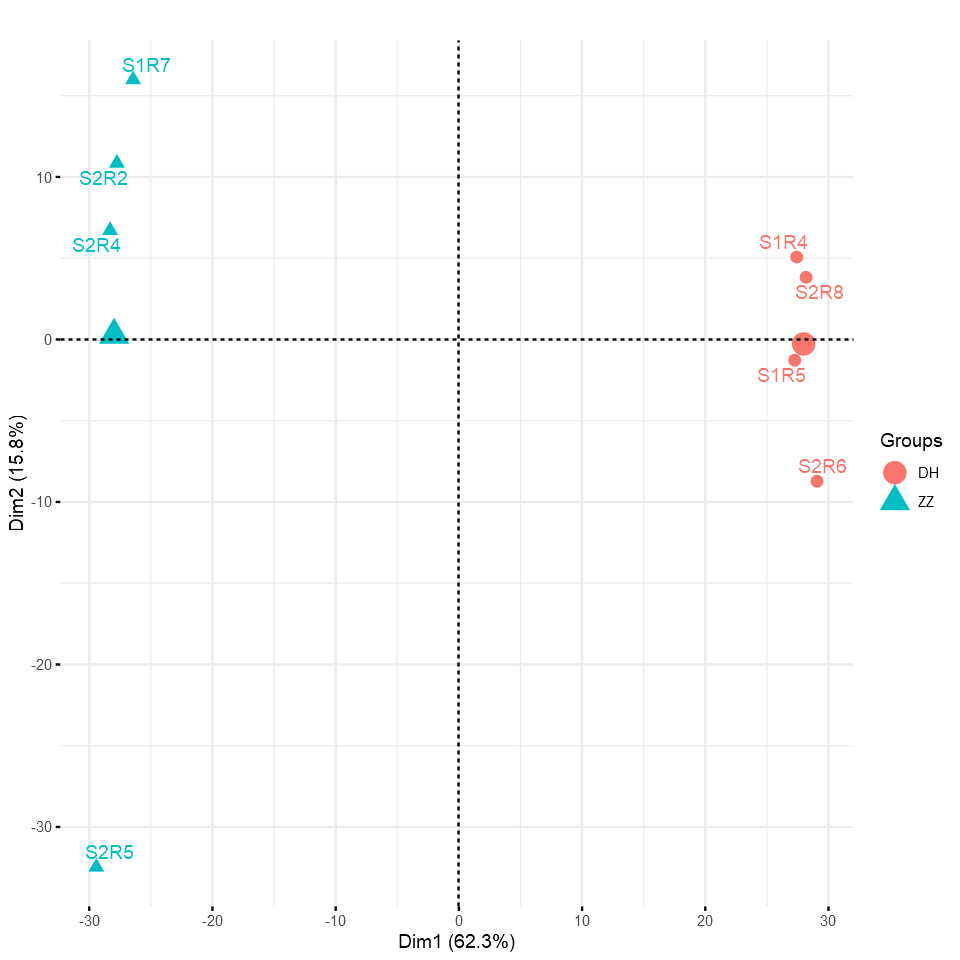

In [39]:
options(repr.plot.width = 8, repr.plot.height = 8)
fviz_pca_ind(res.pca, habillage = META$Condition, title = "", pointsize = 3, repel = TRUE) -> p1
p1

In [40]:
# ggsave(file.path(OUTPUT_DIR, str_glue("pca_{COMPARISON}.pdf")), plot = p1, dpi = 300, width = 8, height = 8)

In [41]:
# getwd()

In [42]:
# library(help = "grDevices")

#### Paper PCA

In [43]:
res.pca$ind$coord %>%
    as.data.frame() %>%
    rownames_to_column("Sample") -> pca_svd

pca_svd$Condition = META$Condition

pc1 = round(res.pca$eig[1,2], 2)
pc2 = round(res.pca$eig[2,2], 2)

In [44]:
# levels(pca_svd$Condition) = c("C. m", "C. m/M. s")

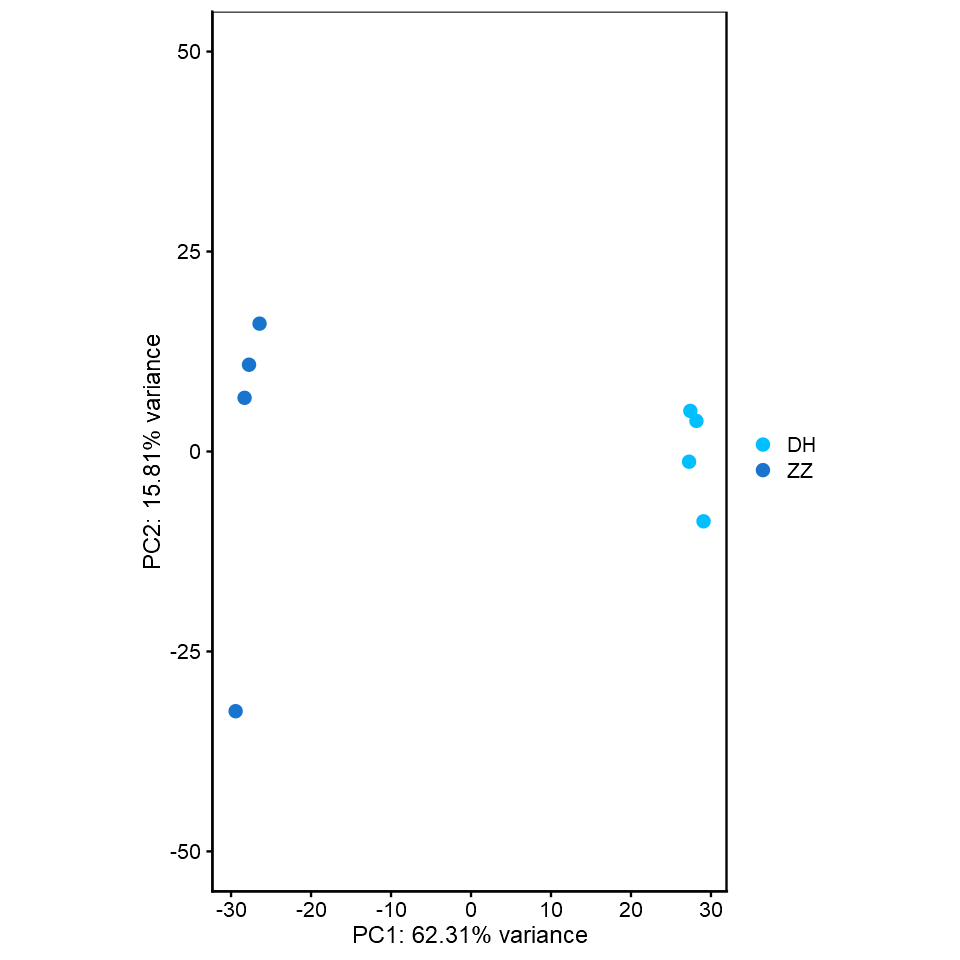

In [45]:
options(repr.plot.width = 8, repr.plot.height = 8)

ggplot(pca_svd, aes(Dim.1, Dim.2, color = Condition, label = Sample)) +
    geom_point(size = 3, show.legend = TRUE) +
    #geom_text(aes(label = name), hjust=1, vjust=-1) +
    xlab(paste0("PC1: ", pc1, "% variance")) +
    ylab(paste0("PC2: ", pc2, "% variance")) +
    ylim(-50, 50) +
    coord_fixed() +
    scale_color_manual(values = c("deepskyblue", "dodgerblue3")) +
    theme_cowplot() +
    theme(
        legend.title = element_blank(),
        panel.border = element_rect(colour = "black", fill = NA, size = 0.5)) -> p4

p4

In [46]:
# ggsave(file.path(OUTPUT_DIR, str_glue("pca_paper_{COMPARISON}.pdf")), plot = p1, dpi = 300, width = 8, height = 8)

### Hierarchical Clustering

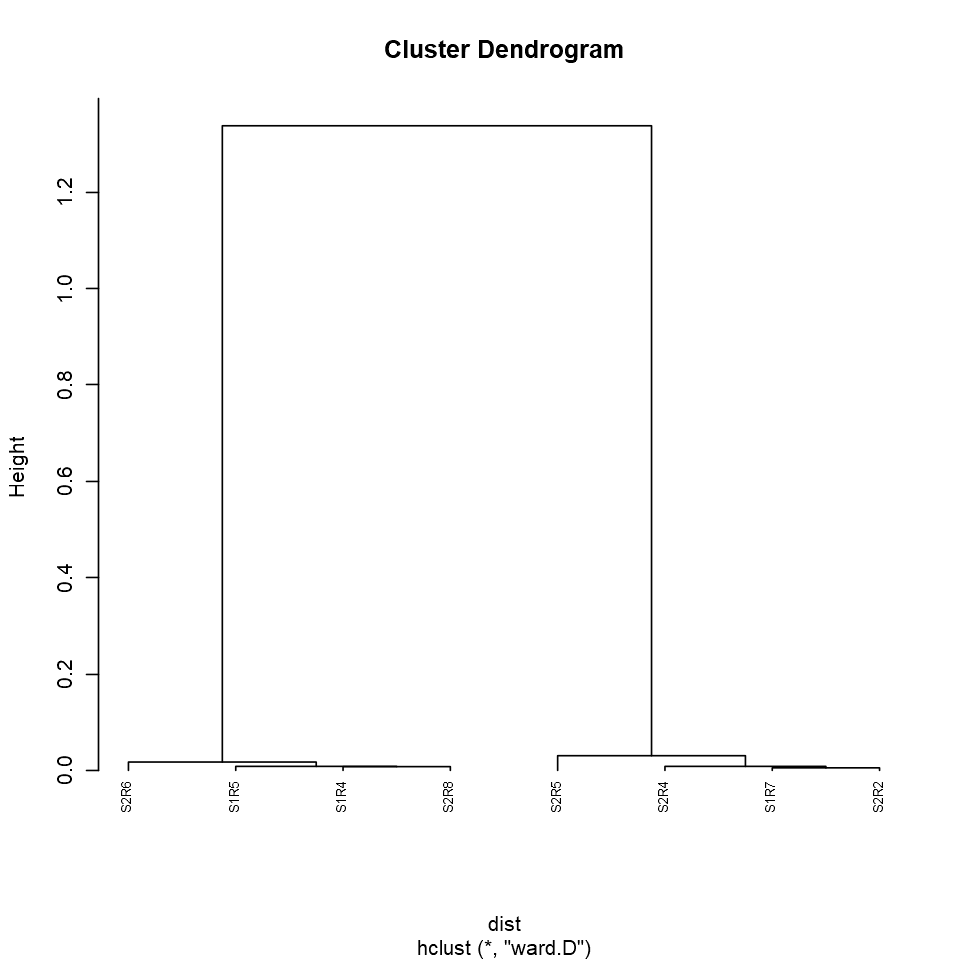

In [47]:
options(repr.plot.width = 8, repr.plot.height = 8)
dist = as.dist(1 - cor(assay(rld), method = "pearson"))
hclust = hclust(dist, method = "ward.D")
plot(hclust, cex = 0.6, hang = -1)

In [48]:
pdf(file.path(OUTPUT_DIR, str_glue("clustering_{COMPARISON}.pdf")), width = 10, height = 8)
plot(hclust, cex = 0.6, hang = -1)
dev.off()

png 
  2

### Differential Expression Analysis

In [49]:
dds_de = DESeq(dds)

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [50]:
CONTRAST = rev(resultsNames(dds_de))[1]

In [51]:
CONTRAST

[1] "Condition_ZZ_vs_DH"

#### Gene-wise Dispersion

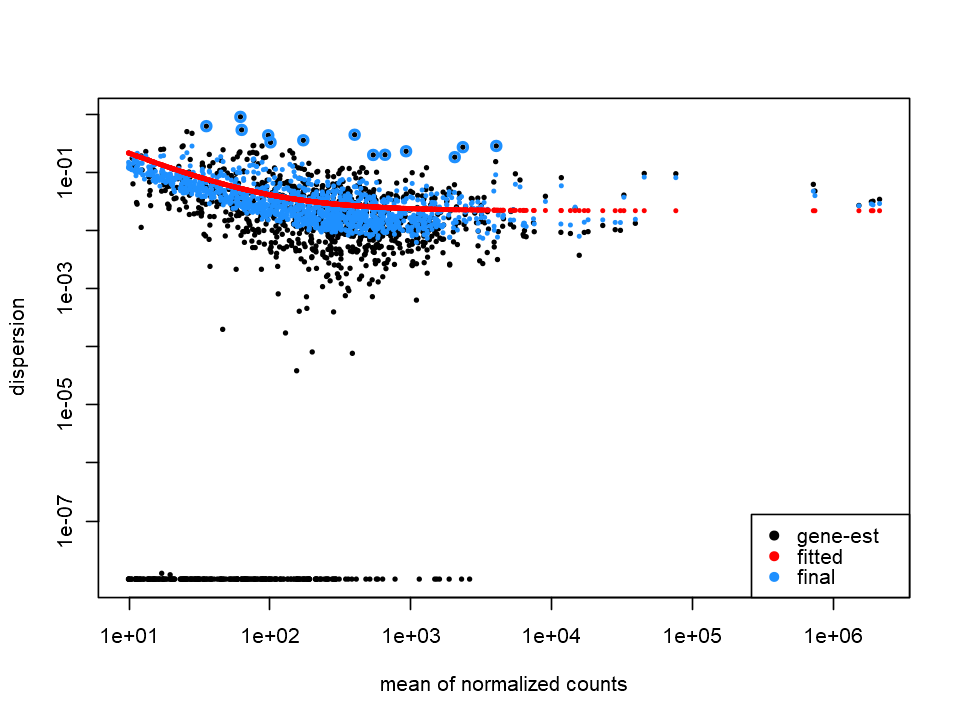

In [52]:
options(repr.plot.width = 8, repr.plot.height = 6)
plotDispEsts(dds_de)

In [53]:
pdf(file.path(OUTPUT_DIR, str_glue("deseq2_dispersion_{COMPARISON}.pdf")), width = 8, height = 6)
plotDispEsts(dds_de)
dev.off()

png 
  2

#### Shrunken log2 Fold-changes

In [54]:
res_unshrunken = results(dds_de, alpha = PADJ_CUTOFF)
resLFC = lfcShrink(dds_de, coef = CONTRAST, type = "apeglm", res = res_unshrunken)

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



In [55]:
summary(resLFC)


out of 1258 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 412, 33%
LFC < 0 (down)     : 404, 32%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 10)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [56]:
resLFC %>%
    as.data.frame() %>%
    rownames_to_column(var = "gene") -> resLFC_tb

#### MA Plot

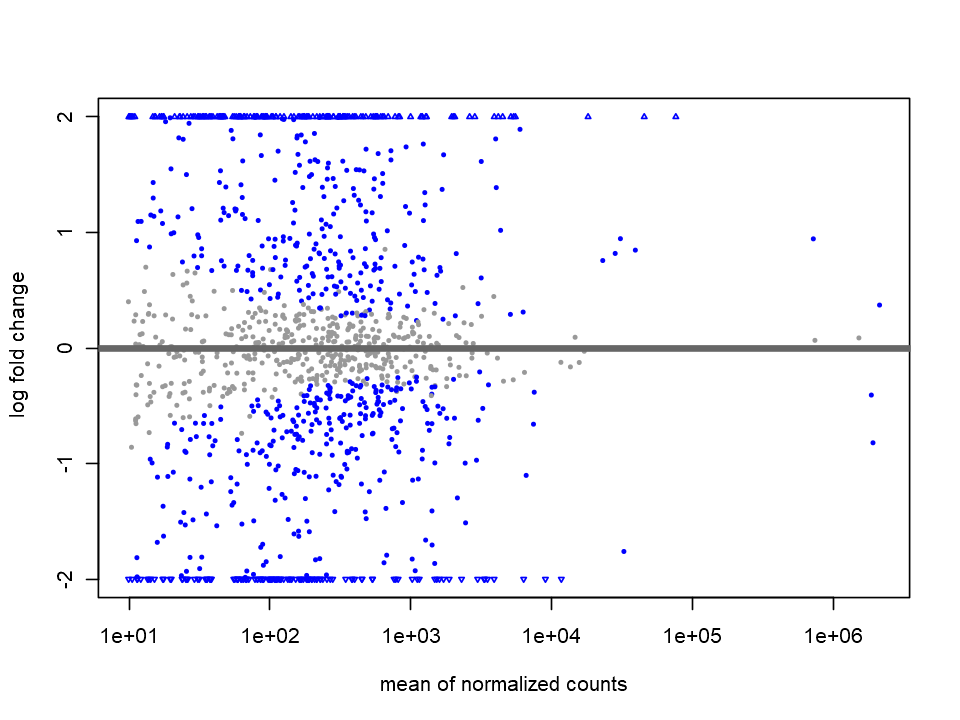

In [57]:
options(repr.plot.width = 8, repr.plot.height = 6)
DESeq2::plotMA(resLFC, ylim=c(-2,2))

In [58]:
pdf(file.path(OUTPUT_DIR, str_glue("deseq2_ma_{COMPARISON}.pdf")), width = 8, height = 6)
DESeq2::plotMA(resLFC, ylim=c(-2,2))
dev.off()

png 
  2

#### P-value Distribution

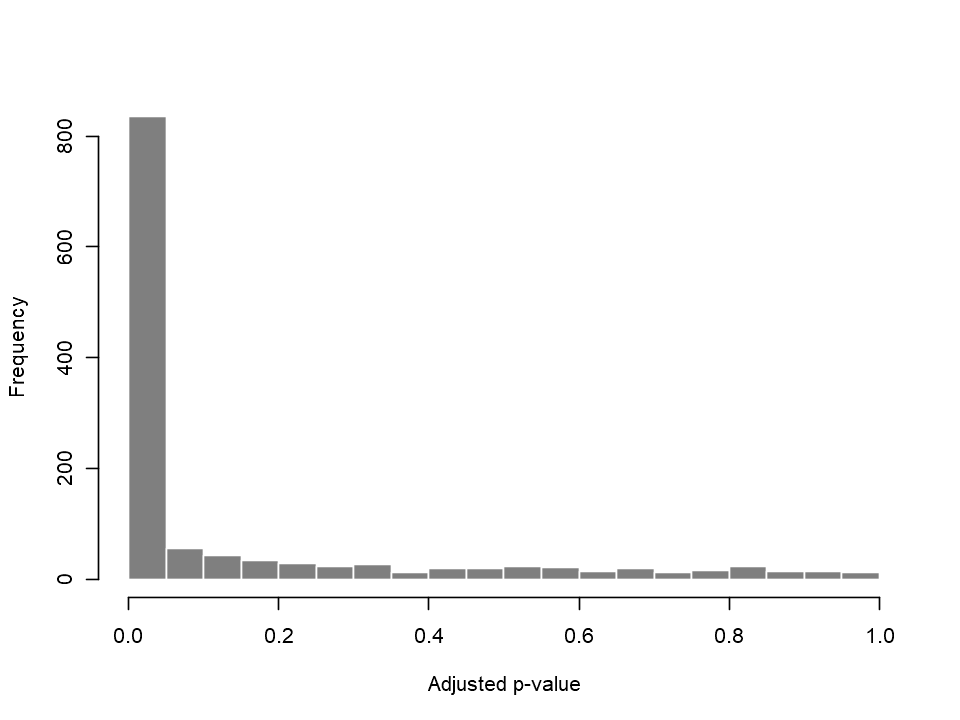

In [59]:
options(repr.plot.width = 8, repr.plot.height = 6)
hist(resLFC$pvalue[resLFC$baseMean > 1], breaks = 0:20/20,
     col = "grey50", border = "white", xlab = "Adjusted p-value", main = "")

In [60]:
pdf(file.path(OUTPUT_DIR, str_glue("deseq2_pvalue_{COMPARISON}.pdf")), width = 8, height = 6)
hist(resLFC$pvalue[resLFC$baseMean > 1], breaks = 0:20/20,
     col = "grey50", border = "white", xlab = "p-values", main = "")
dev.off()

png 
  2

#### Volcano

In [61]:
resLFC_tb %>%
    filter(padj < PADJ_CUTOFF & abs(log2FoldChange) > 2) %>% pull(gene) -> select_genes

Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."
Warning message:
"Ignoring unknown parameters: xlim, ylim"


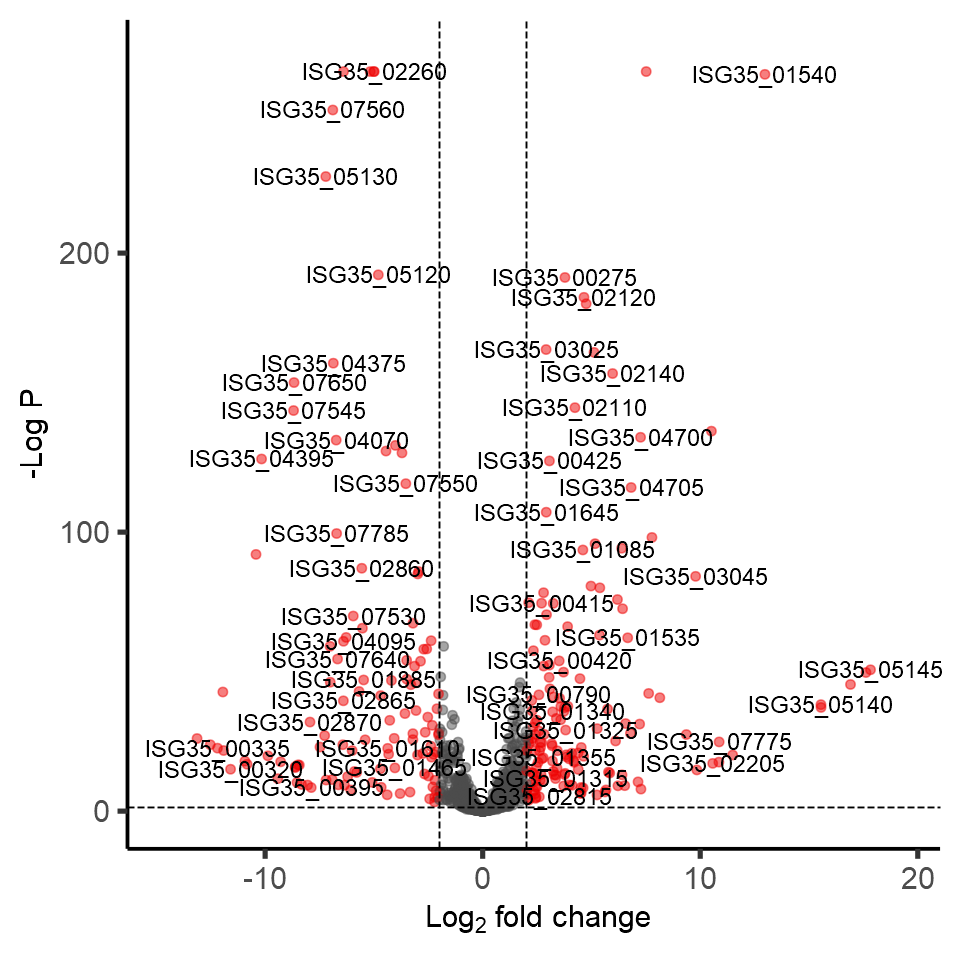

In [62]:
options(repr.plot.width = 8, repr.plot.height = 8)

EnhancedVolcano(
    resLFC_tb,
    lab = resLFC_tb$gene,
    x = 'log2FoldChange',
    y = 'padj',
    ylab = "-Log P",
#     ylim = c(0, 7),
    selectLab = select_genes,
    title = NULL,
    subtitle = NULL,
    caption = NULL,
    col = c("grey30", "grey30", "grey30", "red2"),
    legendPosition = 'none',
    gridlines.major = FALSE,
    gridlines.minor = FALSE,
    FCcutoff = 2.0,
    pCutoff = 0.05) -> p2

p2

In [63]:
# ggsave(file.path(OUTPUT_DIR, str_glue("volcano_cm_{COMPARISON}.pdf")), plot = p2, dpi = 300, width = 8, height = 8)

### Quantification Heatmap

In [64]:
resLFC_tb %>%
    filter(padj < PADJ_CUTOFF & (log2FoldChange < LFC_CUTOFF_DOWN | log2FoldChange > LFC_CUTOFF_UP)) -> sig_genes

In [65]:
sig_genes %>% pull(gene) -> sig_genes_ids

In [66]:
counts(dds_de, normalized = TRUE) %>%
    as_tibble(rownames = NA) %>%
    rownames_to_column(var = "gene") -> normalized_counts

In [67]:
normalized_counts %>%
    filter(gene %in% sig_genes_ids) %>%
    mutate(mean_counts = rowMeans(dplyr::select(., rownames(META)))) %>%
    arrange(-mean_counts) %>%
    column_to_rownames(var = "gene") %>%
    dplyr::select(rownames(META)) -> sig_genes_counts

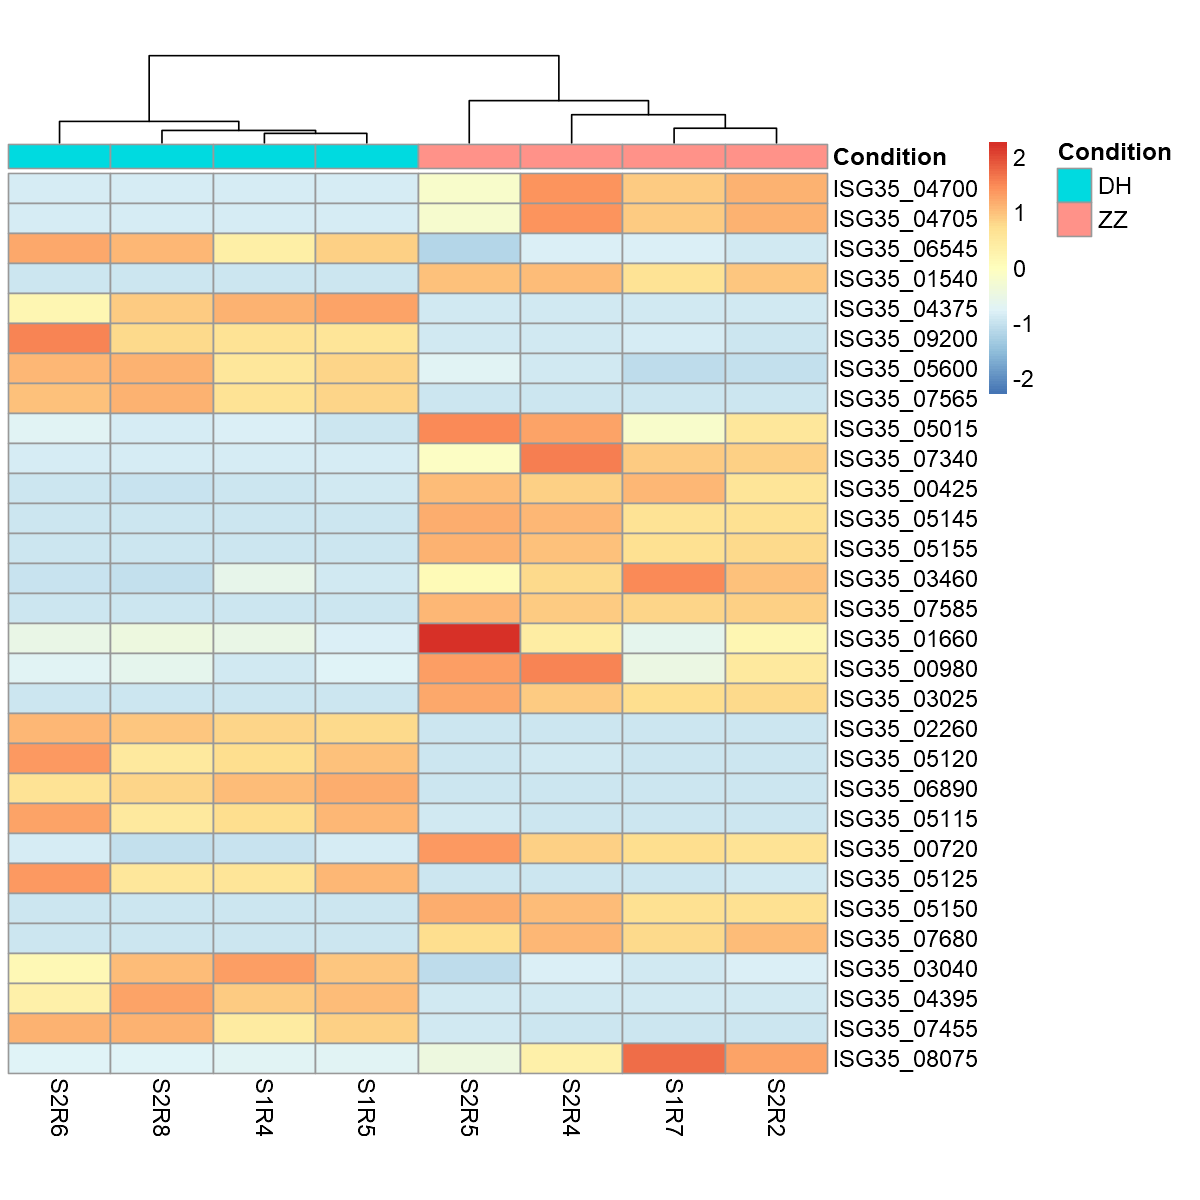

In [68]:
options(repr.plot.width = 10, repr.plot.height = 10)
pheatmap(sig_genes_counts %>% head(30),
         cluster_cols = T,
         cluster_rows = F,
         show_rownames = T,
         annotation_col = META,
         annotation_row = NULL,
         fontsize = 14,
         scale = "row",
         fontsize_row = 14,
         cellheight = 18) -> p3

In [69]:
# ggsave(file.path(OUTPUT_DIR, str_glue("deseq2_heatmap_{COMPARISON}.pdf")), plot = p3, dpi = 300, width = 10, height = 10)

In [70]:
# resLFC_tb %>% write_tsv("F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/DESeq2_ZZ_DH.tsv")

# Heat Map all genes

In [71]:
# resLFC_tb %>%
#     filter(padj < PADJ_CUTOFF) -> sig_genes

In [72]:
# sig_genes %>% pull(gene) -> sig_genes_ids

In [73]:
# counts(dds_de, normalized = FALSE) %>%
#     as_tibble(rownames = NA) %>%
#     rownames_to_column(var = "gene") -> normalized_counts

In [74]:
# normalized_counts %>%
#     filter(gene %in% sig_genes_ids) %>%
#     mutate(mean_counts = rowMeans(dplyr::select(., rownames(META)))) %>%
#     arrange(-mean_counts) %>%
#     column_to_rownames(var = "gene") %>%
#     dplyr::select(rownames(META)) -> sig_genes_counts

In [75]:
# options(repr.plot.width = 5, repr.plot.height = 30)
# pheatmap(sig_genes_counts,
#          cluster_cols = T,
#          cluster_rows = T,
#          show_rownames = F,
#          annotation_col = META,
#          annotation_row = NULL,
#          fontsize = 14,
#          scale = "row",
#          fontsize_row = 1.5,
#          cellheight = 1.5) -> p3

In [76]:
# ggsave(file.path(OUTPUT_DIR, str_glue("deseq2_heatmap_{COMPARISON}_all_genes.svg")), plot = p3, dpi = 300, width = 5, height = 30,limitsize = FALSE)

## MM vs DH

In [77]:
COUNTS = COUNTS_MM_DH
META = meta.mm_dh
COMPARISON = "MM_DH"
TX2GENE = read_tsv("F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/tx2gene_MM_DH.tsv", col_names = c("TXNAME", "GENEID"), show_col_types = FALSE)

### Read Salmon Counts

In [78]:
txi = tximport(COUNTS, type = "salmon", tx2gene = TX2GENE)

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 


summarizing abundance

summarizing counts

summarizing length



In [79]:
dds = DESeqDataSetFromTximport(txi, colData = META, design = as.formula(DESEQ2_FORMULA))
keep = rowMeans(counts(dds)) >= MIN_COUNTS
dds = dds[keep,]

using counts and average transcript lengths from tximport



### Principal Component Analysis

In [80]:
rld = rlog(dds, blind = FALSE)

using 'avgTxLength' from assays(dds), correcting for library size



**Calculate the variance for each gene**

In [81]:
rv = rowVars(assay(rld))

**Principal component analysis**

In [82]:
t(assay(rld)) -> pca_mtx
res.pca = PCA(pca_mtx, graph = FALSE)

**Biplot of samples and genes**

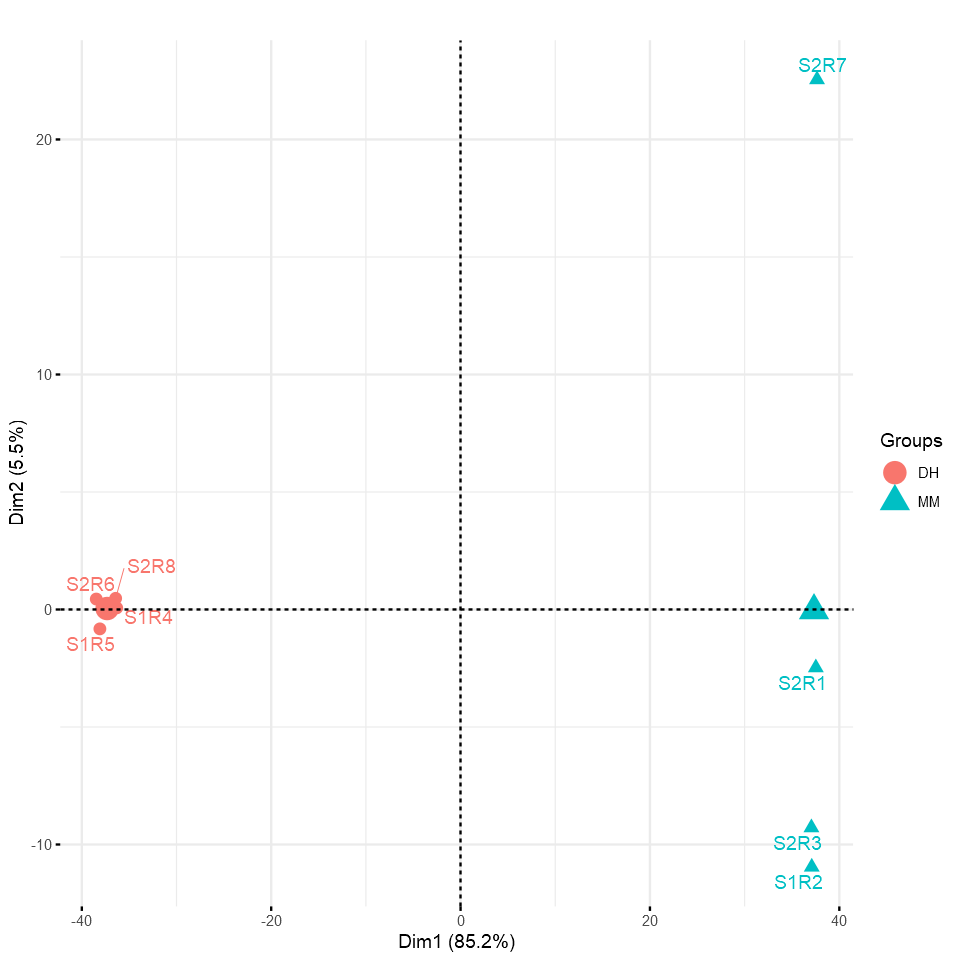

In [83]:
options(repr.plot.width = 8, repr.plot.height = 8)
fviz_pca_ind(res.pca, habillage = META$Condition, title = "", pointsize = 3, repel = TRUE) -> p1
p1

In [84]:
# ggsave(file.path(OUTPUT_DIR, str_glue("pca_{COMPARISON}.pdf")), plot = p1, dpi = 300, width = 8, height = 8)

#### Paper PCA

In [85]:
res.pca$ind$coord %>%
    as.data.frame() %>%
    rownames_to_column("Sample") -> pca_svd

pca_svd$Condition = META$Condition

pc1 = round(res.pca$eig[1,2], 2)
pc2 = round(res.pca$eig[2,2], 2)

In [86]:
# levels(pca_svd$Condition) = c("C. m", "C. m/M. s")

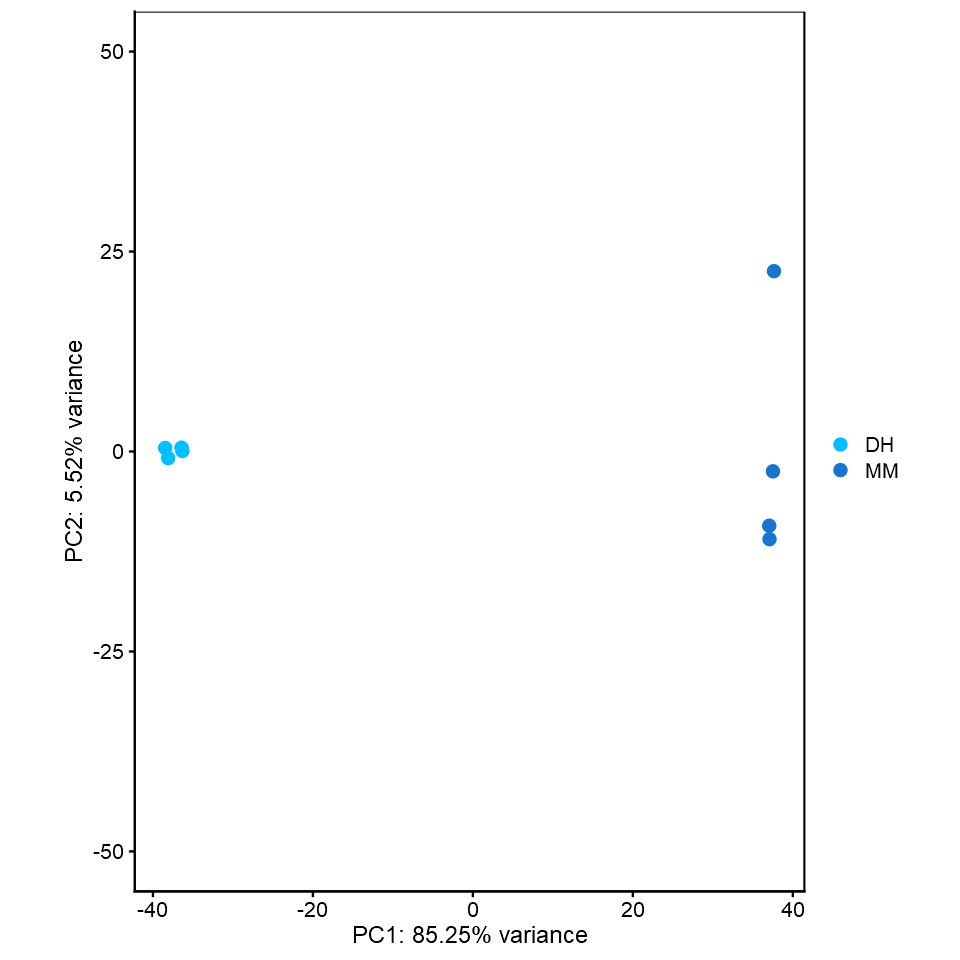

In [87]:
options(repr.plot.width = 8, repr.plot.height = 8)

ggplot(pca_svd, aes(Dim.1, Dim.2, color = Condition, label = Sample)) +
    geom_point(size = 3, show.legend = TRUE) +
    #geom_text(aes(label = name), hjust=1, vjust=-1) +
    xlab(paste0("PC1: ", pc1, "% variance")) +
    ylab(paste0("PC2: ", pc2, "% variance")) +
    ylim(-50, 50) +
    coord_fixed() +
    scale_color_manual(values = c("deepskyblue", "dodgerblue3")) +
    theme_cowplot() +
    theme(
        legend.title = element_blank(),
        panel.border = element_rect(colour = "black", fill = NA, size = 0.5)) -> p4

p4

In [88]:
# ggsave(file.path(OUTPUT_DIR, str_glue("pca_paper_{COMPARISON}.pdf")), plot = p1, dpi = 300, width = 10, height = 8)

### Hierarchical Clustering

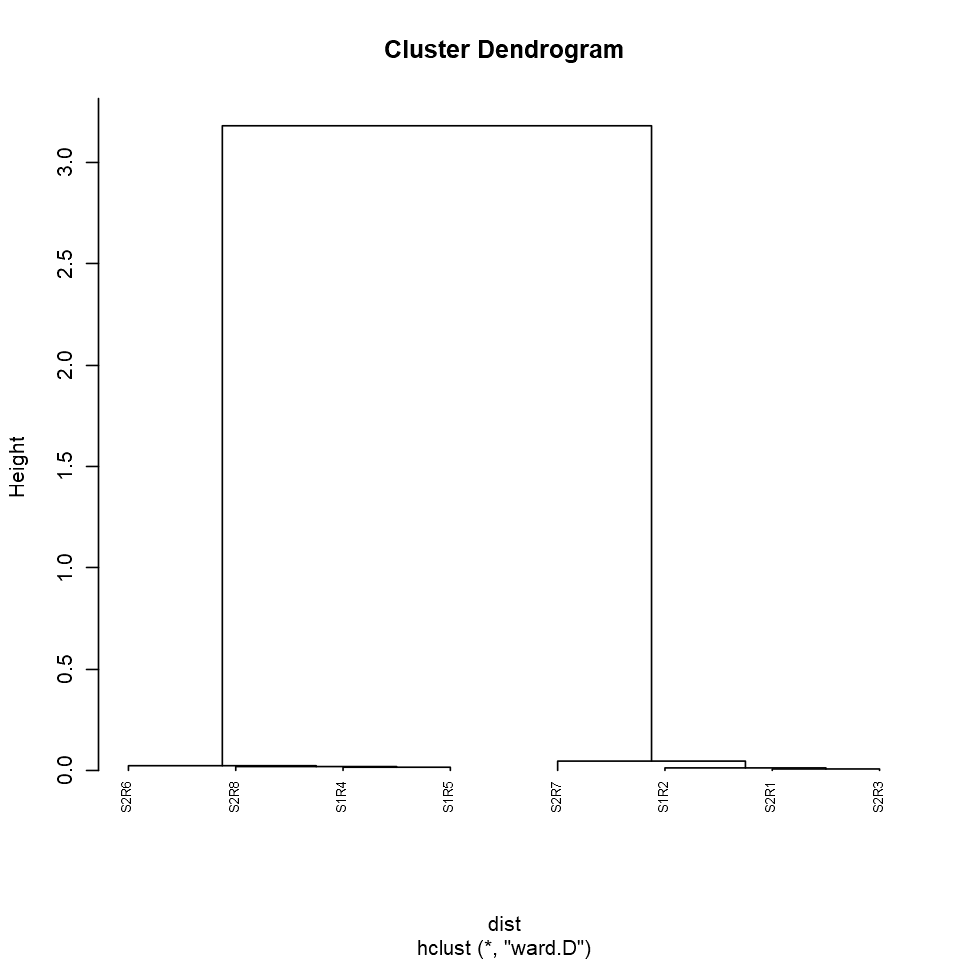

In [89]:
options(repr.plot.width = 8, repr.plot.height = 8)
dist = as.dist(1 - cor(assay(rld), method = "pearson"))
hclust = hclust(dist, method = "ward.D")
plot(hclust, cex = 0.6, hang = -1)

In [90]:
pdf(file.path(OUTPUT_DIR, str_glue("clustering_{COMPARISON}.pdf")), width = 10, height = 8)
plot(hclust, cex = 0.6, hang = -1)
dev.off()

png 
  2

### Differential Expression Analysis

In [91]:
dds_de = DESeq(dds)

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [92]:
CONTRAST = rev(resultsNames(dds_de))[1]

In [93]:
CONTRAST

[1] "Condition_MM_vs_DH"

#### Gene-wise Dispersion

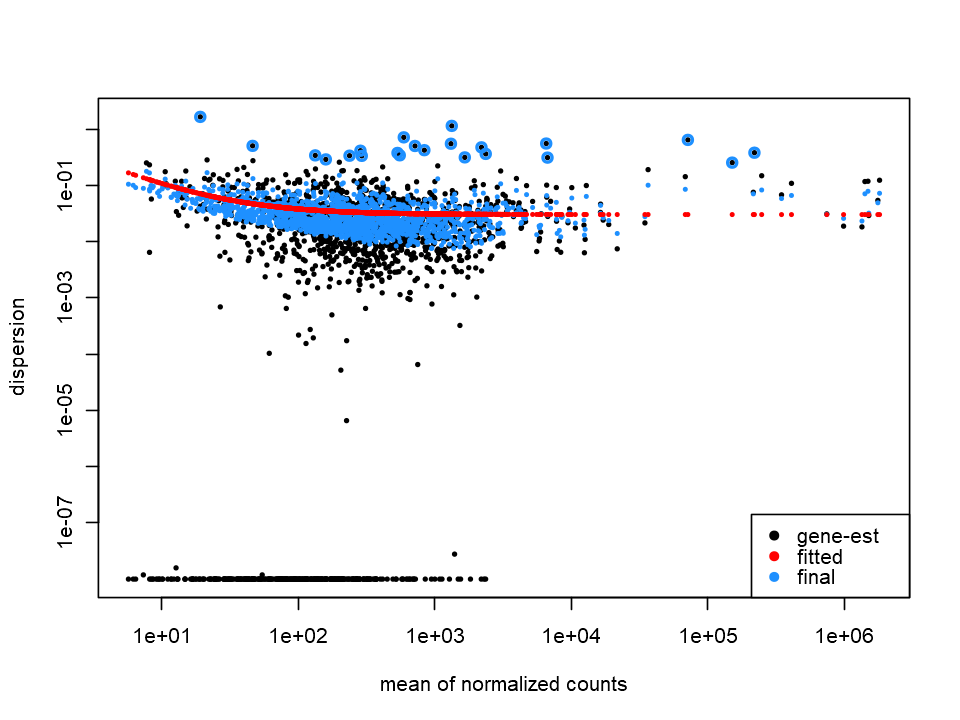

In [94]:
options(repr.plot.width = 8, repr.plot.height = 6)
plotDispEsts(dds_de)

In [95]:
pdf(file.path(OUTPUT_DIR, str_glue("deseq2_dispersion_{COMPARISON}.pdf")), width = 8, height = 6)
plotDispEsts(dds_de)
dev.off()

png 
  2

#### Shrunken log2 Fold-changes

In [96]:
res_unshrunken = results(dds_de, alpha = PADJ_CUTOFF)
resLFC = lfcShrink(dds_de, coef = CONTRAST, type = "apeglm", res = res_unshrunken)

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



In [97]:
summary(resLFC)


out of 1635 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 851, 52%
LFC < 0 (down)     : 631, 39%
outliers [1]       : 1, 0.061%
low counts [2]     : 0, 0%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [98]:
resLFC %>%
    as.data.frame() %>%
    rownames_to_column(var = "gene") -> resLFC_tb

#### MA Plot

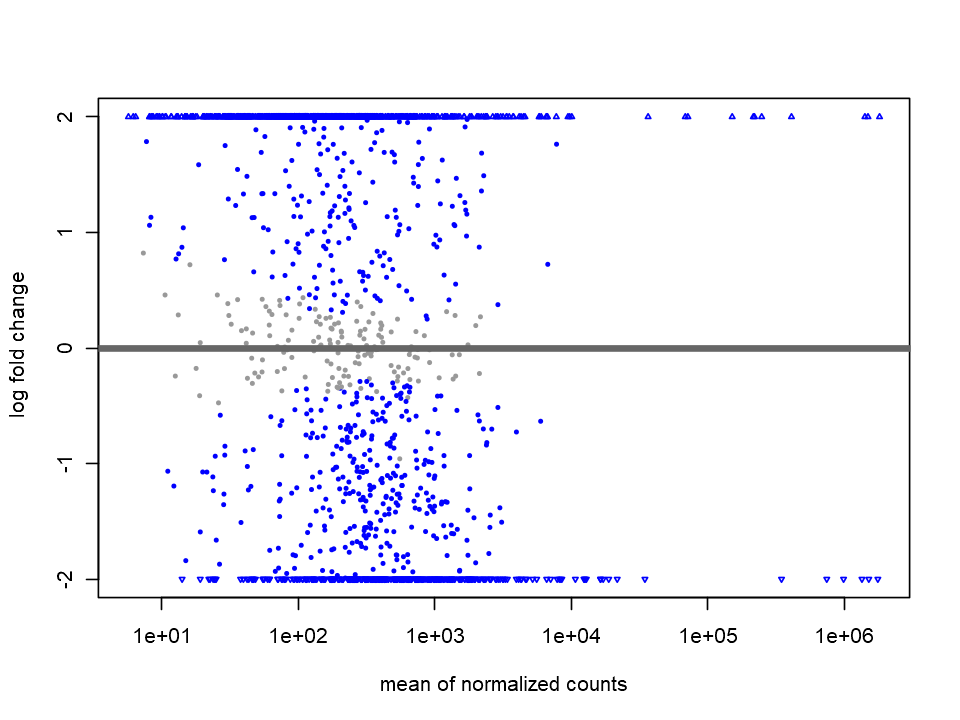

In [99]:
options(repr.plot.width = 8, repr.plot.height = 6)
DESeq2::plotMA(resLFC, ylim=c(-2,2))

In [100]:
pdf(file.path(OUTPUT_DIR, str_glue("deseq2_ma_{COMPARISON}.pdf")), width = 8, height = 6)
DESeq2::plotMA(resLFC, ylim=c(-2,2))
dev.off()

png 
  2

#### P-value Distribution

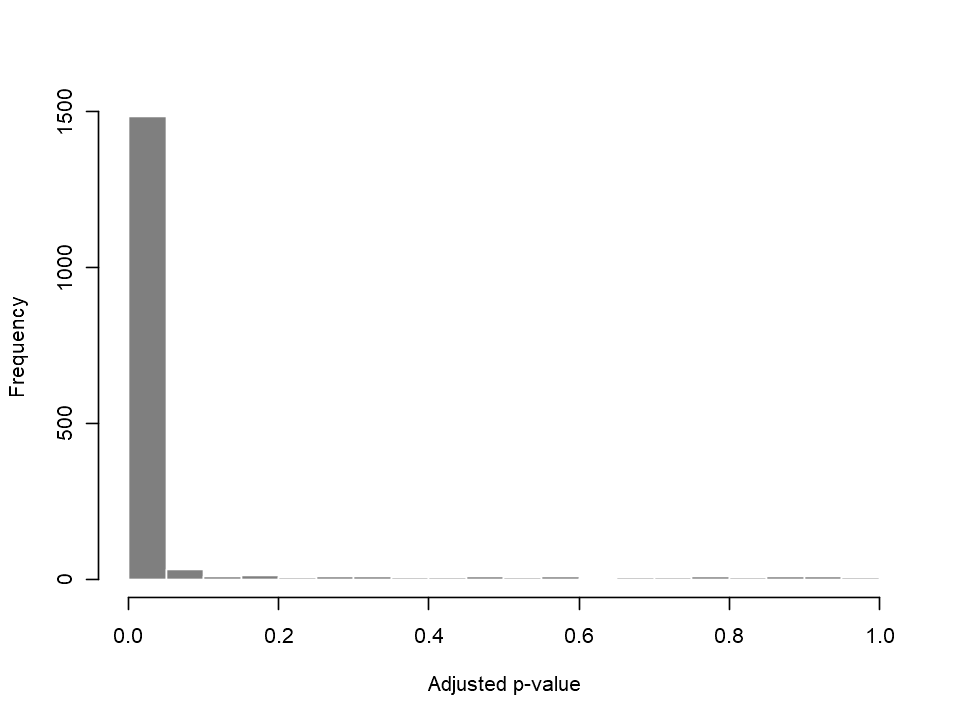

In [101]:
options(repr.plot.width = 8, repr.plot.height = 6)
hist(resLFC$pvalue[resLFC$baseMean > 1], breaks = 0:20/20,
     col = "grey50", border = "white", xlab = "Adjusted p-value", main = "")

In [102]:
pdf(file.path(OUTPUT_DIR, str_glue("deseq2_pvalue_{COMPARISON}.pdf")), width = 8, height = 6)
hist(resLFC$pvalue[resLFC$baseMean > 1], breaks = 0:20/20,
     col = "grey50", border = "white", xlab = "p-values", main = "")
dev.off()

png 
  2

#### Volcano

In [103]:
resLFC_tb %>%
    filter(padj < PADJ_CUTOFF & abs(log2FoldChange) > 2) %>% pull(gene) -> select_genes

Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."
Warning message:
"Ignoring unknown parameters: xlim, ylim"


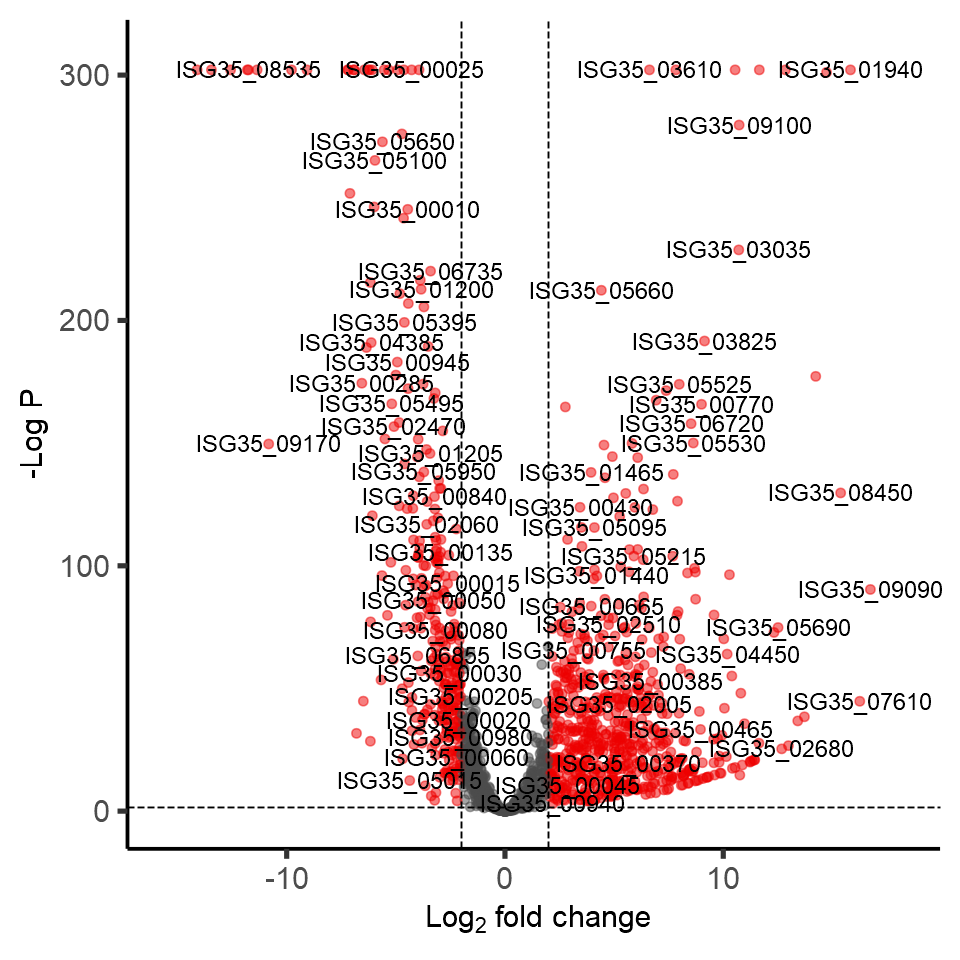

In [104]:
options(repr.plot.width = 8, repr.plot.height = 8)

EnhancedVolcano(
    resLFC_tb,
    lab = resLFC_tb$gene,
    x = 'log2FoldChange',
    y = 'padj',
    ylab = "-Log P",
#     ylim = c(0, 7),
    selectLab = select_genes,
    title = NULL,
    subtitle = NULL,
    caption = NULL,
    col = c("grey30", "grey30", "grey30", "red2"),
    legendPosition = 'none',
    gridlines.major = FALSE,
    gridlines.minor = FALSE,
    FCcutoff = 2.0,
    pCutoff = 0.05) -> p2

p2

In [105]:
# ggsave(file.path(OUTPUT_DIR, str_glue("volcano_cm_{COMPARISON}.pdf")), plot = p2, dpi = 300, width = 8, height = 8)

### Quantification Heatmap

In [106]:
resLFC_tb %>%
    filter(padj < PADJ_CUTOFF & (log2FoldChange < LFC_CUTOFF_DOWN | log2FoldChange > LFC_CUTOFF_UP)) -> sig_genes

In [107]:
sig_genes %>% pull(gene) -> sig_genes_ids

In [108]:
counts(dds_de, normalized = TRUE) %>%
    as_tibble(rownames = NA) %>%
    rownames_to_column(var = "gene") -> normalized_counts

In [109]:
normalized_counts %>%
    filter(gene %in% sig_genes_ids) %>%
    mutate(mean_counts = rowMeans(dplyr::select(., rownames(META)))) %>%
    arrange(-mean_counts) %>%
    column_to_rownames(var = "gene") %>%
    dplyr::select(rownames(META)) -> sig_genes_counts

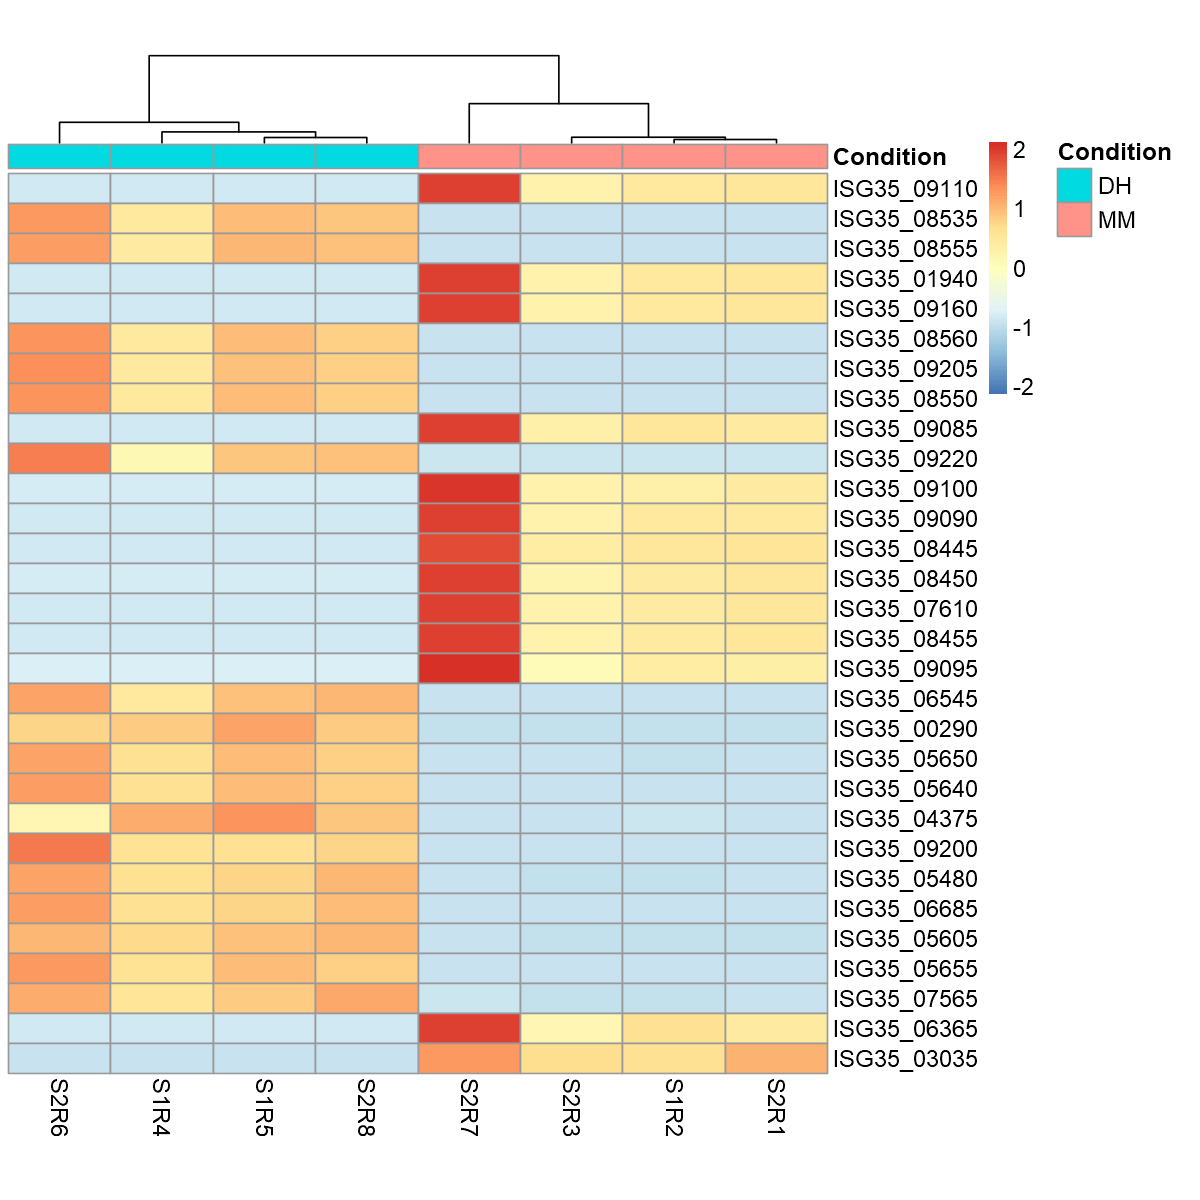

In [110]:
options(repr.plot.width = 10, repr.plot.height = 10)
pheatmap(sig_genes_counts %>% head(30),
         cluster_cols = T,
         cluster_rows = F,
         show_rownames = T,
         annotation_col = META,
         annotation_row = NULL,
         fontsize = 14,
         scale = "row",
         fontsize_row = 14,
         cellheight = 18) -> p3

In [111]:
# ggsave(file.path(OUTPUT_DIR, str_glue("deseq2_heatmap_{COMPARISON}.pdf")), plot = p3, dpi = 300, width = 10, height = 10)

In [112]:
# resLFC_tb %>% write_tsv("F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/DESeq2_MM_DH.tsv")

# Heat Map all genes

In [113]:
# options(repr.plot.width = 5, repr.plot.height = 30)
# pheatmap(sig_genes_counts,
#          cluster_cols = T,
#          cluster_rows = T,
#          show_rownames = F,
#          annotation_col = META,
#          annotation_row = NULL,
#          fontsize = 14,
#          scale = "row",
#          fontsize_row = 1.5,
#          cellheight = 1.5) -> p3

In [114]:
# ggsave(file.path(OUTPUT_DIR, str_glue("deseq2_heatmap_{COMPARISON}_all_genes.svg")), plot = p3, dpi = 300, width = 5, height = 30,limitsize = FALSE)

## ZZ vs MM

In [115]:
COUNTS = COUNTS_ZZ_MM
META = meta.zz_mm
COMPARISON = "ZZ_MM"
TX2GENE = read_tsv("F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/tx2gene_ZZ_MM.tsv", col_names = c("TXNAME", "GENEID"), show_col_types = FALSE)

### Read Salmon Counts

In [116]:
txi = tximport(COUNTS, type = "salmon", tx2gene = TX2GENE)

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 


summarizing abundance

summarizing counts

summarizing length



In [117]:
dds = DESeqDataSetFromTximport(txi, colData = META, design = as.formula(DESEQ2_FORMULA))
keep = rowMeans(counts(dds)) >= MIN_COUNTS
dds = dds[keep,]

using counts and average transcript lengths from tximport



### Principal Component Analysis

In [118]:
rld = rlog(dds, blind = FALSE)

using 'avgTxLength' from assays(dds), correcting for library size



**Calculate the variance for each gene**

In [119]:
rv = rowVars(assay(rld))

**Principal component analysis**

In [120]:
t(assay(rld)) -> pca_mtx
res.pca = PCA(pca_mtx, graph = FALSE)

**Biplot of samples and genes**

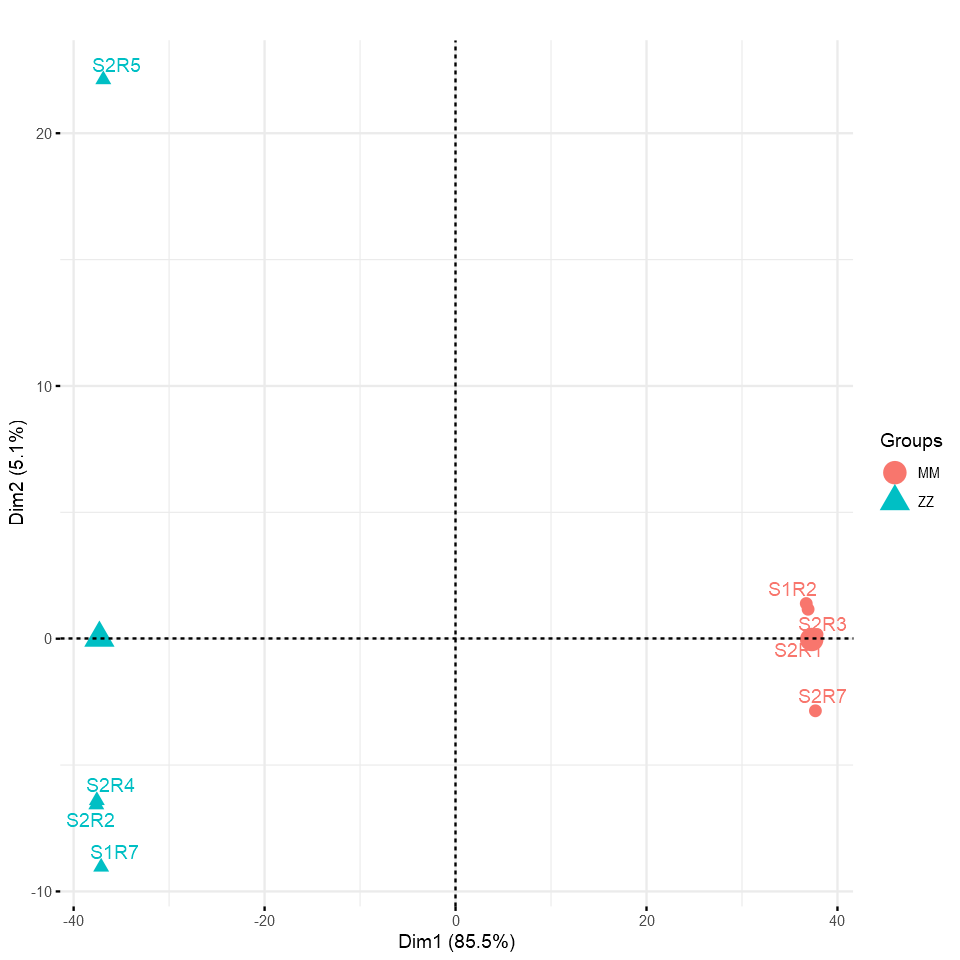

In [121]:
options(repr.plot.width = 8, repr.plot.height = 8)
fviz_pca_ind(res.pca, habillage = META$Condition, title = "", pointsize = 3, repel = TRUE) -> p1
p1

In [122]:
# ggsave(file.path(OUTPUT_DIR, str_glue("pca_{COMPARISON}.pdf")), plot = p1, dpi = 300, width = 8, height = 8)

#### Paper PCA

In [123]:
res.pca$ind$coord %>%
    as.data.frame() %>%
    rownames_to_column("Sample") -> pca_svd

pca_svd$Condition = META$Condition

pc1 = round(res.pca$eig[1,2], 2)
pc2 = round(res.pca$eig[2,2], 2)

In [124]:
# levels(pca_svd$Condition) = c("C. m", "C. m/M. s")

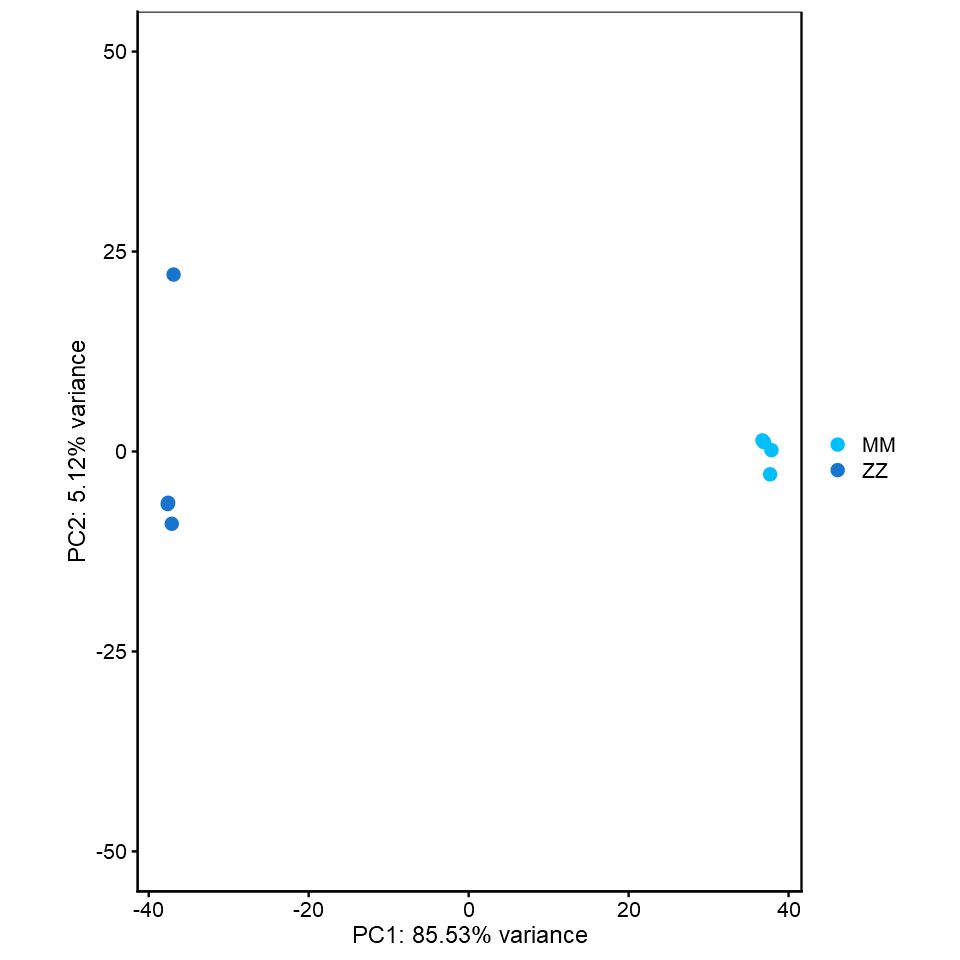

In [125]:
options(repr.plot.width = 8, repr.plot.height = 8)

ggplot(pca_svd, aes(Dim.1, Dim.2, color = Condition, label = Sample)) +
    geom_point(size = 3, show.legend = TRUE) +
    #geom_text(aes(label = name), hjust=1, vjust=-1) +
    xlab(paste0("PC1: ", pc1, "% variance")) +
    ylab(paste0("PC2: ", pc2, "% variance")) +
    ylim(-50, 50) +
    coord_fixed() +
    scale_color_manual(values = c("deepskyblue", "dodgerblue3")) +
    theme_cowplot() +
    theme(
        legend.title = element_blank(),
        panel.border = element_rect(colour = "black", fill = NA, size = 0.5)) -> p4

p4

In [126]:
# ggsave(file.path(OUTPUT_DIR, str_glue("pca_paper_{COMPARISON}.pdf")), plot = p1, dpi = 300, width = 8, height = 8)

### Hierarchical Clustering

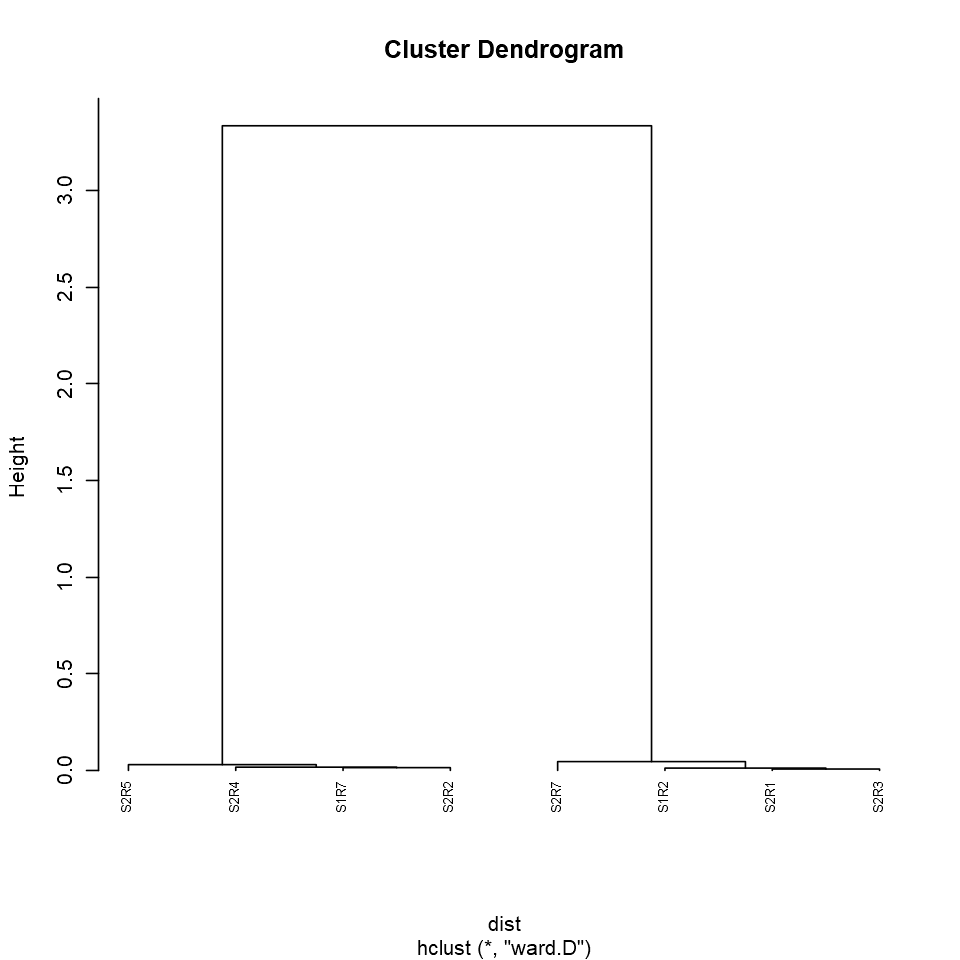

In [127]:
options(repr.plot.width = 8, repr.plot.height = 8)
dist = as.dist(1 - cor(assay(rld), method = "pearson"))
hclust = hclust(dist, method = "ward.D")
plot(hclust, cex = 0.6, hang = -1)

In [128]:
pdf(file.path(OUTPUT_DIR, str_glue("clustering_{COMPARISON}.pdf")), width = 10, height = 8)
plot(hclust, cex = 0.6, hang = -1)
dev.off()

png 
  2

### Differential Expression Analysis

In [129]:
dds_de = DESeq(dds)

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [130]:
CONTRAST = rev(resultsNames(dds_de))[1]

In [131]:
CONTRAST

[1] "Condition_ZZ_vs_MM"

#### Gene-wise Dispersion

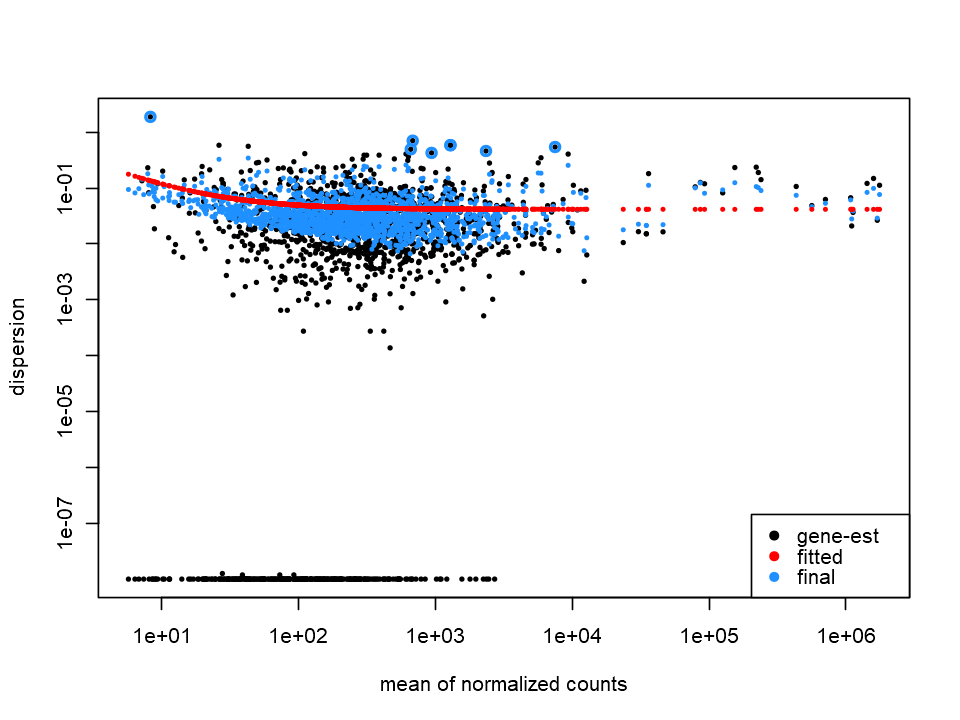

In [132]:
options(repr.plot.width = 8, repr.plot.height = 6)
plotDispEsts(dds_de)

In [133]:
pdf(file.path(OUTPUT_DIR, str_glue("deseq2_dispersion_{COMPARISON}.pdf")), width = 8, height = 6)
plotDispEsts(dds_de)
dev.off()

png 
  2

#### Shrunken log2 Fold-changes

In [134]:
res_unshrunken = results(dds_de, alpha = PADJ_CUTOFF)
resLFC = lfcShrink(dds_de, coef = CONTRAST, type = "apeglm", res = res_unshrunken)

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



In [135]:
summary(resLFC)


out of 1627 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 649, 40%
LFC < 0 (down)     : 849, 52%
outliers [1]       : 2, 0.12%
low counts [2]     : 0, 0%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [136]:
resLFC %>%
    as.data.frame() %>%
    rownames_to_column(var = "gene") -> resLFC_tb

#### MA Plot

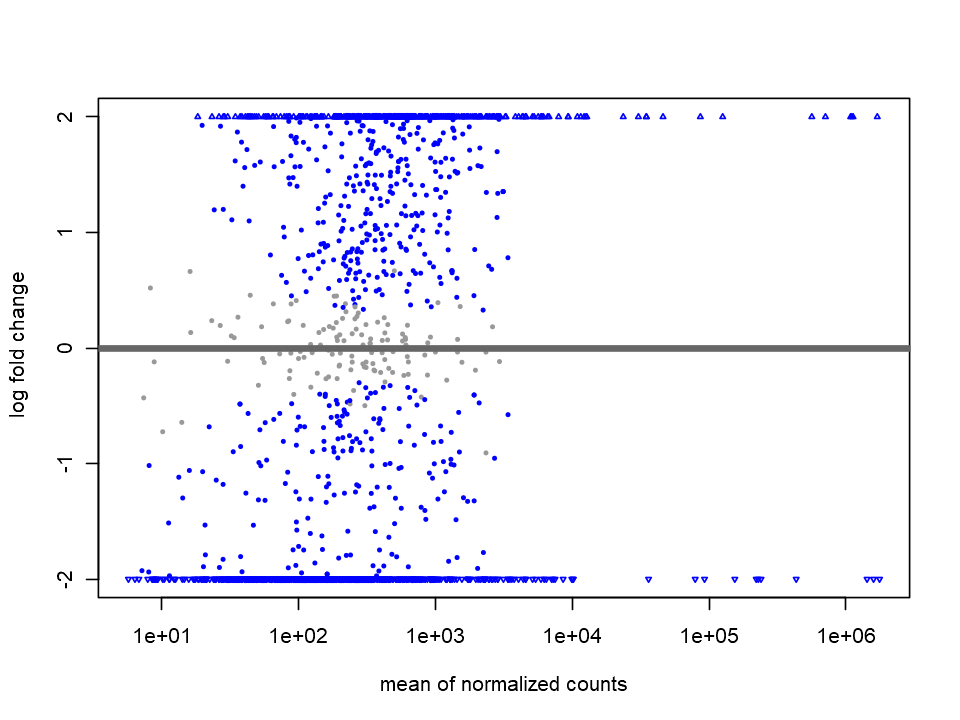

In [137]:
options(repr.plot.width = 8, repr.plot.height = 6)
DESeq2::plotMA(resLFC, ylim=c(-2,2))

In [138]:
pdf(file.path(OUTPUT_DIR, str_glue("deseq2_ma_{COMPARISON}.pdf")), width = 8, height = 6)
DESeq2::plotMA(resLFC, ylim=c(-2,2))
dev.off()

png 
  2

#### P-value Distribution

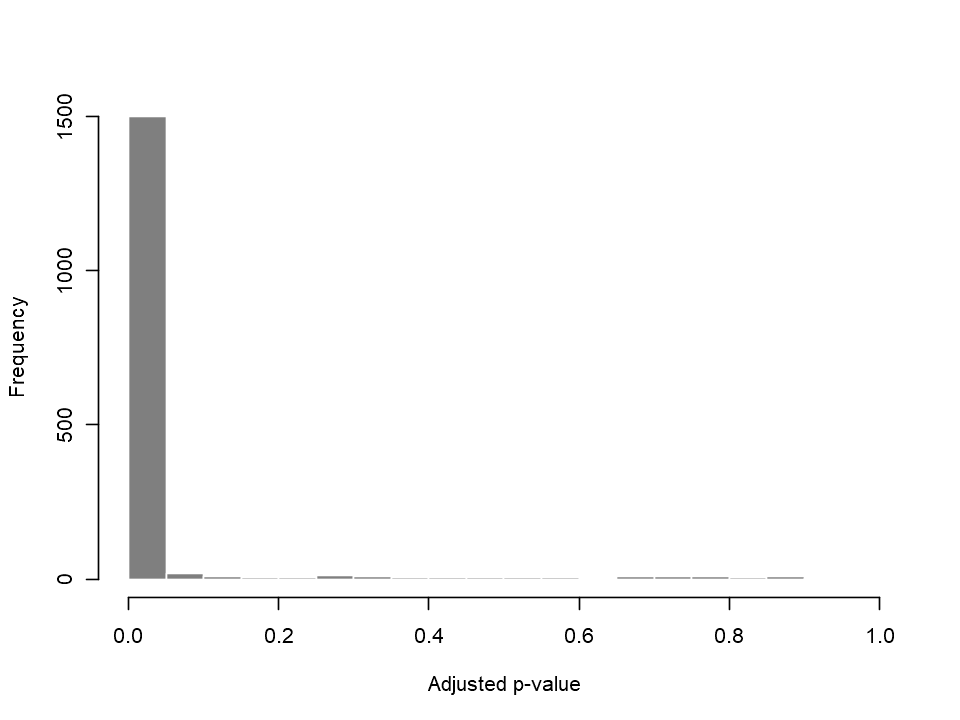

In [139]:
options(repr.plot.width = 8, repr.plot.height = 6)
hist(resLFC$pvalue[resLFC$baseMean > 1], breaks = 0:20/20,
     col = "grey50", border = "white", xlab = "Adjusted p-value", main = "")

In [140]:
pdf(file.path(OUTPUT_DIR, str_glue("deseq2_pvalue_{COMPARISON}.pdf")), width = 8, height = 6)
hist(resLFC$pvalue[resLFC$baseMean > 1], breaks = 0:20/20,
     col = "grey50", border = "white", xlab = "p-values", main = "")
dev.off()

png 
  2

#### Volcano

In [141]:
resLFC_tb %>%
    filter(padj < PADJ_CUTOFF & abs(log2FoldChange) > 2) %>% pull(gene) -> select_genes

Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."
Warning message:
"Ignoring unknown parameters: xlim, ylim"


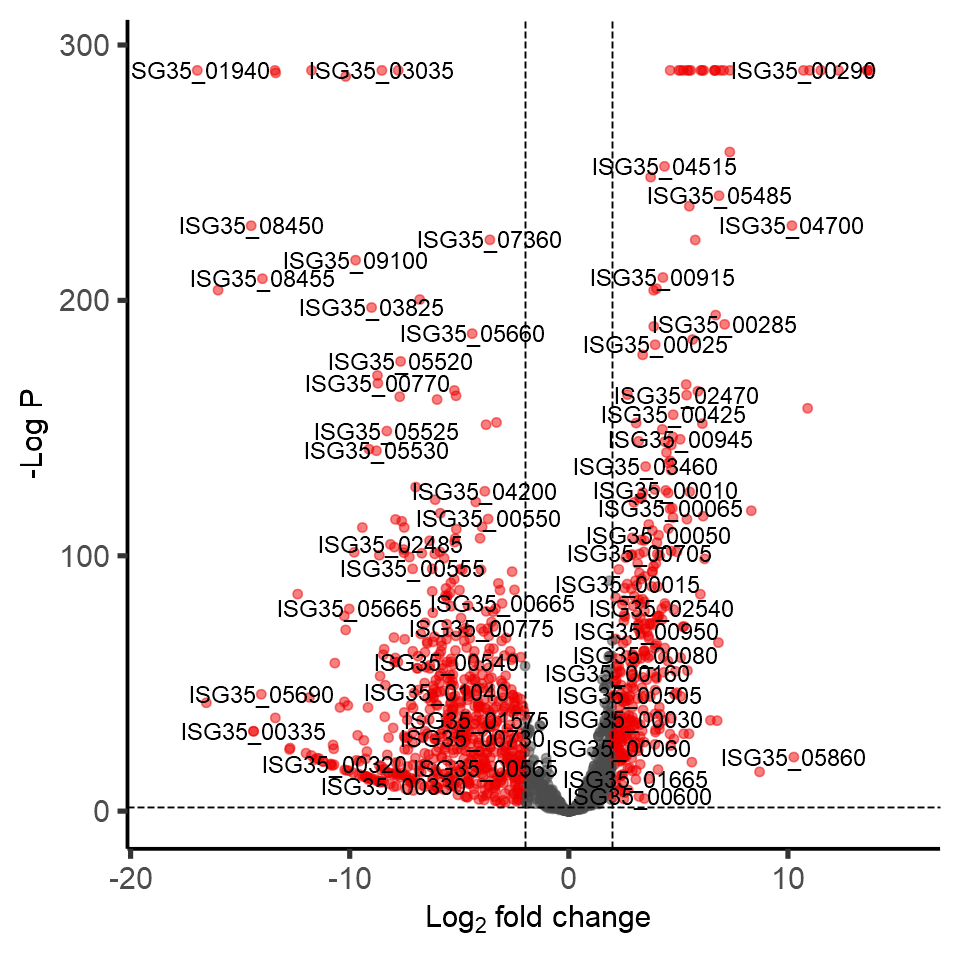

In [142]:
options(repr.plot.width = 8, repr.plot.height = 8)

EnhancedVolcano(
    resLFC_tb,
    lab = resLFC_tb$gene,
    x = 'log2FoldChange',
    y = 'padj',
    ylab = "-Log P",
#     ylim = c(0, 7),
    selectLab = select_genes,
    title = NULL,
    subtitle = NULL,
    caption = NULL,
    col = c("grey30", "grey30", "grey30", "red2"),
    legendPosition = 'none',
    gridlines.major = FALSE,
    gridlines.minor = FALSE,
    FCcutoff = 2.0,
    pCutoff = 0.05) -> p2

p2

In [143]:
# ggsave(file.path(OUTPUT_DIR, str_glue("volcano_cm_{COMPARISON}.pdf")), plot = p2, dpi = 300, width = 8, height = 8)

### Quantification Heatmap

In [144]:
resLFC_tb %>%
    filter(padj < PADJ_CUTOFF & (log2FoldChange < LFC_CUTOFF_DOWN | log2FoldChange > LFC_CUTOFF_UP)) -> sig_genes

In [145]:
sig_genes %>% pull(gene) -> sig_genes_ids

In [146]:
counts(dds_de, normalized = TRUE) %>%
    as_tibble(rownames = NA) %>%
    rownames_to_column(var = "gene") -> normalized_counts

In [147]:
normalized_counts %>%
    filter(gene %in% sig_genes_ids) %>%
    mutate(mean_counts = rowMeans(dplyr::select(., rownames(META)))) %>%
    arrange(-mean_counts) %>%
    column_to_rownames(var = "gene") %>%
    dplyr::select(rownames(META)) -> sig_genes_counts

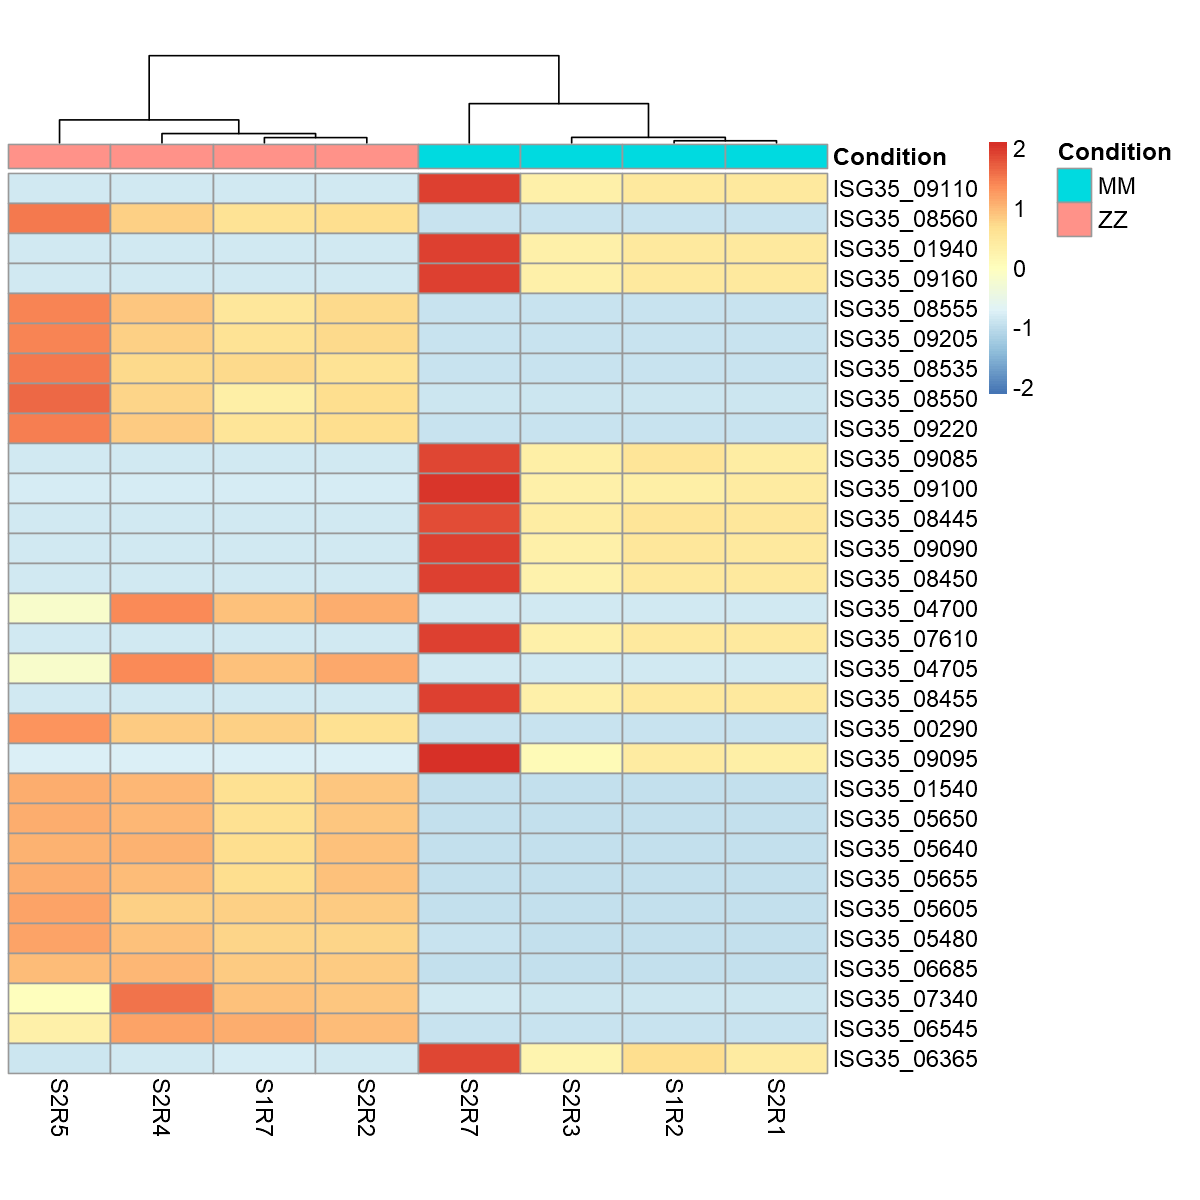

In [148]:
options(repr.plot.width = 10, repr.plot.height = 10)
pheatmap(sig_genes_counts %>% head(30),
         cluster_cols = T,
         cluster_rows = F,
         show_rownames = T,
         annotation_col = META,
         annotation_row = NULL,
         fontsize = 14,
         scale = "row",
         fontsize_row = 14,
         cellheight = 18) -> p3

In [149]:
# ggsave(file.path(OUTPUT_DIR, str_glue("deseq2_heatmap_{COMPARISON}.pdf")), plot = p3, dpi = 300, width = 10, height = 10)

In [150]:
# resLFC_tb %>% write_tsv("F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/DESeq2_ZZ_MM.tsv")

# Heat Map all genes

In [151]:
# options(repr.plot.width = 5, repr.plot.height = 30)
# pheatmap(sig_genes_counts,
#          cluster_cols = T,
#          cluster_rows = T,
#          show_rownames = F,
#          annotation_col = META,
#          annotation_row = NULL,
#          fontsize = 14,
#          scale = "row",
#          fontsize_row = 1.5,
#          cellheight = 1.5) -> p3

In [152]:
# ggsave(file.path(OUTPUT_DIR, str_glue("deseq2_heatmap_{COMPARISON}_all_genes.svg")), plot = p3, dpi = 300, width = 5, height = 30,limitsize = FALSE)

# LFC Heatmap

In [45]:
read_tsv("F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/DESeq2_ZZ_DH.tsv", show_col_types = FALSE) %>%
    filter(padj < PADJ_CUTOFF) %>%
    select(gene, padj, log2FoldChange) %>%
    dplyr::rename(zz_dh.padj = padj, zz_dh.lfc = log2FoldChange) -> r1

In [46]:
read_tsv("F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/DESeq2_MM_DH.tsv", show_col_types = FALSE) %>%
    filter(padj < PADJ_CUTOFF) %>%
    select(gene, padj, log2FoldChange) %>%
    dplyr::rename(mm_dh.padj = padj, mm_dh.lfc = log2FoldChange) -> r2

In [47]:
read_tsv("F://Experimental_Work/Transcriptomics/F6_Exp/DE_Guillermo/Isabella_run2/DESeq2_ZZ_MM.tsv", show_col_types = FALSE) %>%
    filter(padj < PADJ_CUTOFF) %>%
    select(gene, padj, log2FoldChange) %>%
    dplyr::rename(zz_mm.padj = padj, zz_mm.lfc = log2FoldChange) -> r3

In [48]:
r1 %>%
    left_join(r2, by = "gene") %>%
    left_join(r3, by = "gene") %>%
    rowwise() %>%
    mutate(lfc.max = max(abs(zz_dh.lfc), abs(mm_dh.lfc), abs(zz_mm.lfc))) %>%
    mutate(padj.max = min(zz_dh.padj, mm_dh.padj, zz_mm.padj)) -> hm.lfc

In [49]:
hm.lfc %>%
    dplyr::arrange(padj.max) %>%
    column_to_rownames("gene") %>%
    select(zz_dh.lfc, mm_dh.lfc, zz_mm.lfc) %>%
    dplyr::rename(
        `ZZ vs DH` = zz_dh.lfc,
        `MM vs DH` = mm_dh.lfc,
        `ZZ vs MM` = zz_mm.lfc
    ) -> top.lfc

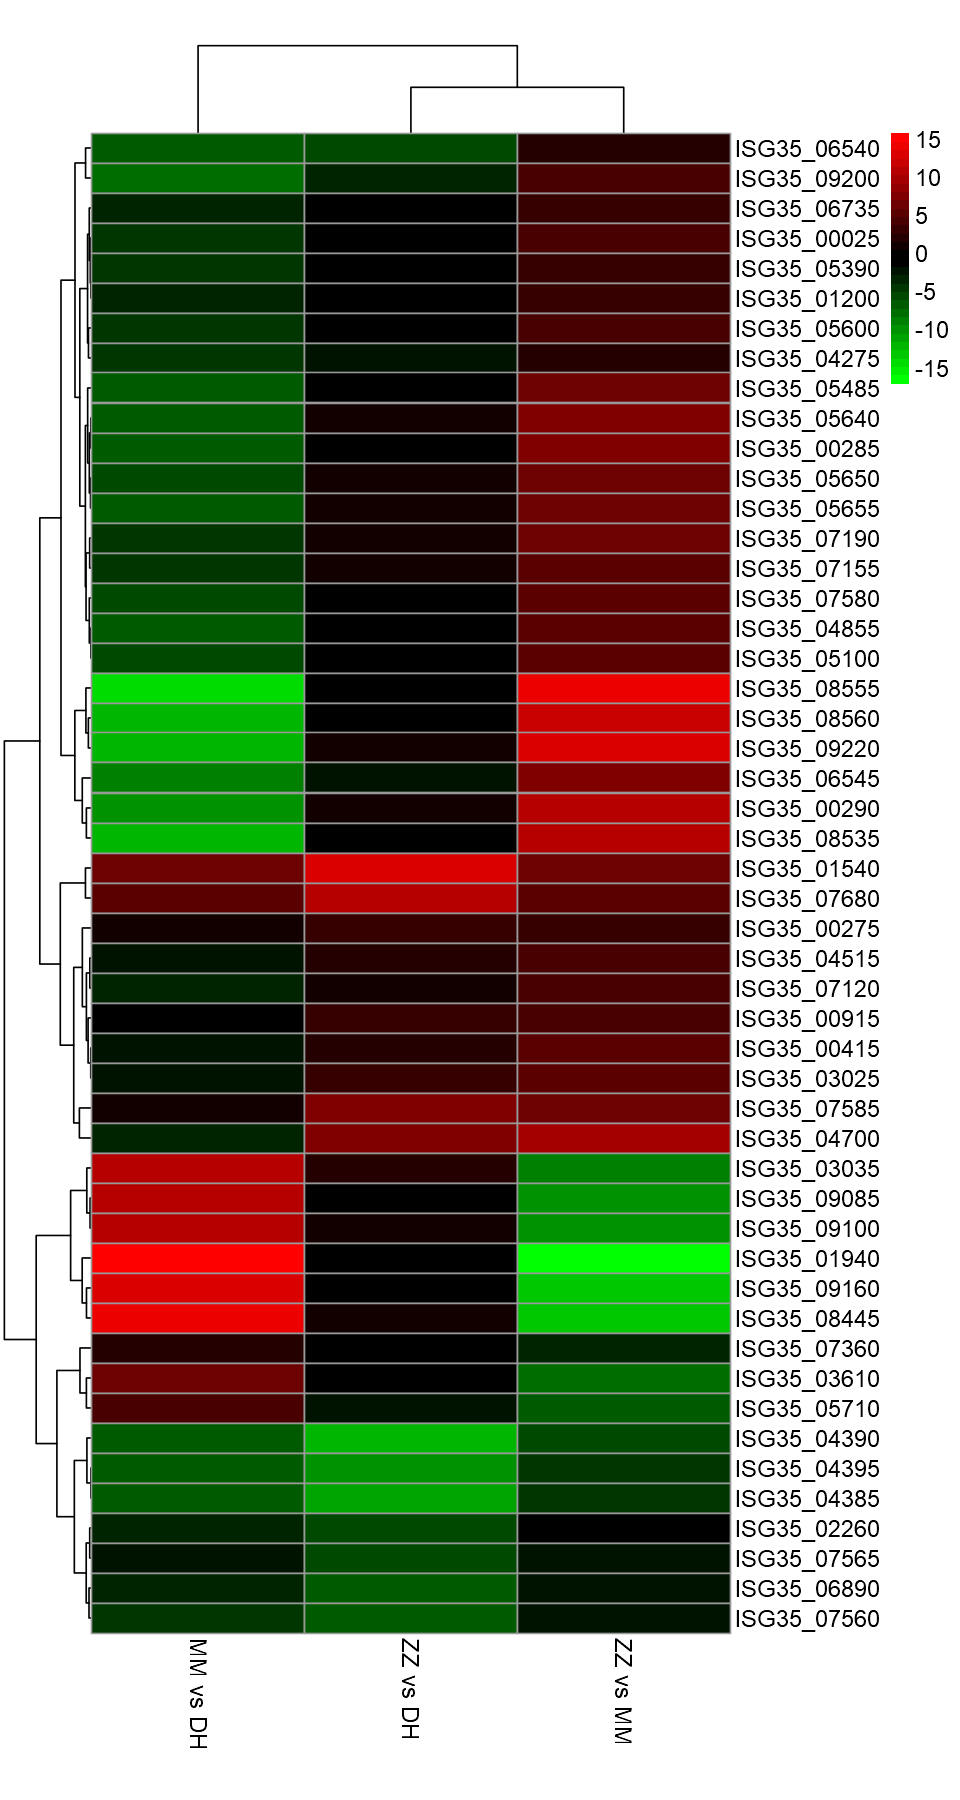

In [54]:
options(repr.plot.width = 8, repr.plot.height = 15)
pheatmap(top.lfc %>% head(50),
         color=greenred(30),
         cluster_cols = T,
         cluster_rows = T,
         show_rownames = T,
         annotation_col = NULL,
         annotation_row = NULL,
         fontsize = 14,
         scale = "none",
         fontsize_row = 14,
         cellheight = 18) -> p.lfc

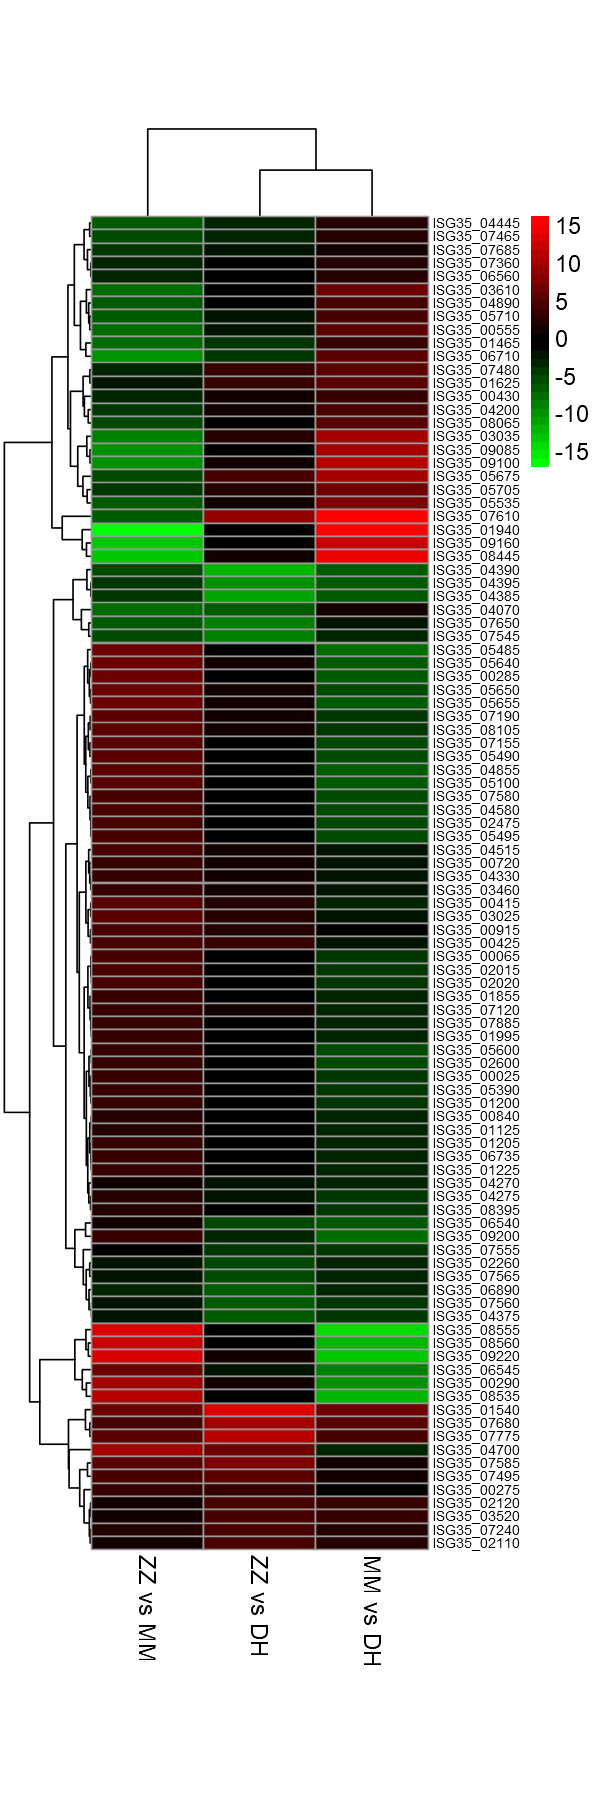

In [191]:
options(repr.plot.width = 5, repr.plot.height = 15)
pheatmap(top.lfc %>% head(100),
         color=greenred(30),
         cluster_cols = T,
         cluster_rows = T,
         show_rownames = T,
         annotation_col = NULL,
         annotation_row = NULL,
         fontsize = 14,
         scale = "none",
         fontsize_row = 8,
         cellheight = 8) -> p.lfc

In [192]:
# saves the file

# ggsave(file.path(OUTPUT_DIR, str_glue("deseq2_heatmap_LFC_100.pdf")), plot = p.lfc, dpi = 300, width = 5, height = 15)
# ggsave(file.path(OUTPUT_DIR, str_glue("deseq2_heatmap_LFC_100.svg")), plot = p.lfc, dpi = 300, width = 5, height = 15)

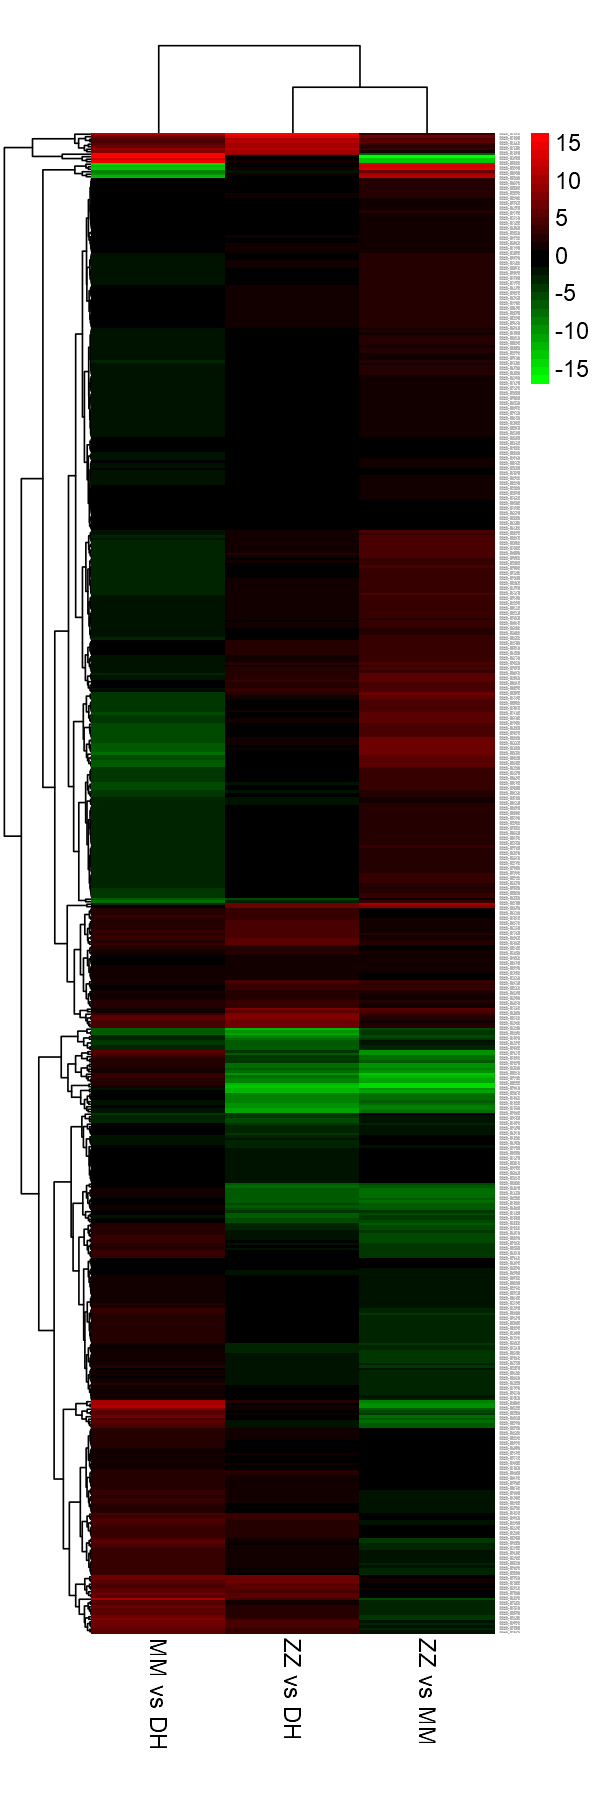

In [186]:
options(repr.plot.width = 5, repr.plot.height = 15)
pheatmap(top.lfc %>% head(600),
         color=greenred(30),
         cluster_cols = T,
         cluster_rows = T,
         show_rownames = T,
         annotation_col = NULL,
         annotation_row = NULL,
         fontsize = 14,
         scale = "none",
         fontsize_row = 1.5,
         cellheight = 1.5) -> p.lfc

In [187]:
# saves the file

# ggsave(file.path(OUTPUT_DIR, str_glue("deseq2_heatmap_LFC_600.pdf")), plot = p.lfc, dpi = 300, width = 5, height = 20)
# ggsave(file.path(OUTPUT_DIR, str_glue("deseq2_heatmap_LFC_600.svg")), plot = p.lfc, dpi = 300, width = 5, height = 20)

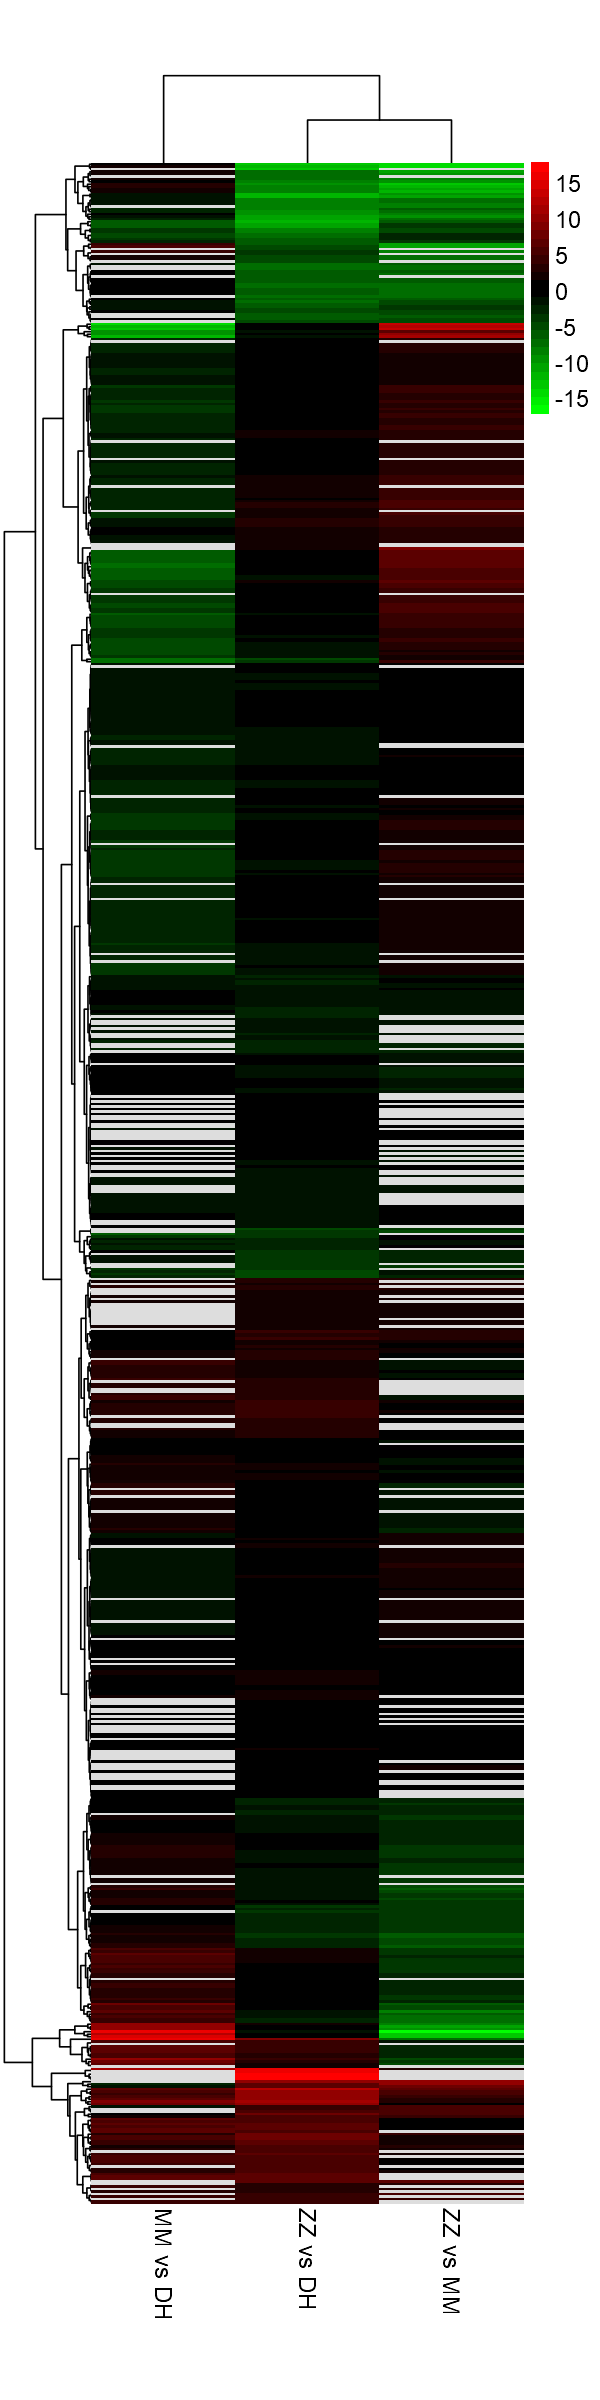

In [176]:
options(repr.plot.width = 5, repr.plot.height = 20)
pheatmap(top.lfc %>% head(1800),
         color=greenred(30),
         cluster_cols = T,
         cluster_rows = T,
         show_rownames = F,
         annotation_col = NULL,
         annotation_row = NULL,
         fontsize = 14,
         scale = "none",
         fontsize_row = 1.5,
         cellheight = 1.5) -> p.lfc

In [178]:
# saves the file

# ggsave(file.path(OUTPUT_DIR, str_glue("deseq2_heatmap_LFC_all.pdf")), plot = p.lfc, dpi = 300, width = 5, height = 20)
# ggsave(file.path(OUTPUT_DIR, str_glue("deseq2_heatmap_LFC_all.svg")), plot = p.lfc, dpi = 300, width = 5, height = 20)

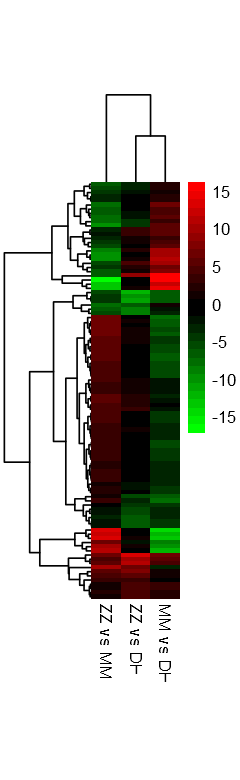

In [58]:
options(repr.plot.width = 2, repr.plot.height = 6.5)
pheatmap(top.lfc %>% head(100),
         color=greenred(30),
         cluster_cols = T,
         cluster_rows = T,
         show_rownames = F,
         annotation_col = NULL,
         annotation_row = NULL,
         fontsize = 10,
         scale = "none",
         fontsize_row = 2.5,
         cellheight = 2.5) -> p.lfc

In [59]:
# saves the file

ggsave(file.path(OUTPUT_DIR, str_glue("deseq2_heatmap_LFC_100_no_label.pdf")), plot = p.lfc, dpi = 300, width = 2, height = 6.5)
ggsave(file.path(OUTPUT_DIR, str_glue("deseq2_heatmap_LFC_no_label.svg")), plot = p.lfc, dpi = 300, width = 2, height = 6.5)

In [153]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19043)

Matrix products: default

locale:
[1] LC_COLLATE=English_United Kingdom.1252 
[2] LC_CTYPE=English_United Kingdom.1252   
[3] LC_MONETARY=English_United Kingdom.1252
[4] LC_NUMERIC=C                           
[5] LC_TIME=English_United Kingdom.1252    

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] gplots_3.1.1                cowplot_1.1.1              
 [3] EnhancedVolcano_1.10.0      ggrepel_0.9.1              
 [5] pheatmap_1.0.12             FactoMineR_2.4             
 [7] factoextra_1.0.7            tximport_1.20.0            
 [9] ggpubr_0.4.0                DESeq2_1.32.0              
[11] SummarizedExperiment_1.22.0 Biobase_2.52.0             
[13] MatrixGenerics_1.4.3        matrixStats_0.61.0         
[15] GenomicRanges_1.44.0        GenomeInfoDb_1.28.4  